In [300]:
import xml.etree.ElementTree as ET
from dna_features_viewer import GraphicFeature, GraphicRecord, BiopythonTranslator
from Bio.Graphics import GenomeDiagram
from reportlab.lib.colors import Color
from reportlab.lib.units import inch


import textwrap
from IPython.display import Image

from matplotlib import cm,colors
from glob import glob
import re
import io
from Bio import SearchIO, SeqIO, Phylo, SeqFeature
import gzip
from functools import partial
import sys

import numpy as np
import pandas as pd
import pybedtools
import scipy

from matplotlib import cm,colors
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway,kruskal,mannwhitneyu, fisher_exact, ttest_ind, pearsonr

workingDir='/path/to/hcom2-invertons/'

In [305]:
def countTotalSites(memeXMLfile):
    tree = ET.parse(memeXMLfile)
    root = tree.getroot()
    try:
        seqIDs=[]
        for motifInd in range(len(root[2])):
            seqIDs=seqIDs+[contribSite.get('sequence_id') for contribSite in root[2][motifInd][3]]
        return len(np.unique(seqIDs))
    except:
        return 0

def countTotalSitesFolder(memeXMLfolder):
    memeXMLfiles=glob(os.path.join(memeXMLfolder,"*meme.xml"))
    return(np.sum([countTotalSites(memeXMLfile) for memeXMLfile in memeXMLfiles]))

def floorLogNearbyGeneCountDf(nearbyGeneCountDf,pValThresh=0.05):
    if len(nearbyGeneCountDf)>0:
        nearbyGeneCountDf['logOddsRatio']=np.log10(nearbyGeneCountDf['odds ratio'])
        try:
            pvalFloor=np.nanmin(nearbyGeneCountDf.loc[nearbyGeneCountDf['p-value']>0,'p-value'])
        except:
            pvalFloor=1e-100
        try:
            lorCeil=np.nanmax(np.abs(nearbyGeneCountDf.loc[np.isfinite(nearbyGeneCountDf['logOddsRatio']),'logOddsRatio']))
        except:
            lorCeil=100
        nearbyGeneCountDf['p-value']=nearbyGeneCountDf['p-value'].replace(0,pvalFloor*1e-10)
        nearbyGeneCountDf['logOddsRatio']=nearbyGeneCountDf['logOddsRatio'].replace(np.inf,.5+lorCeil).replace(-np.inf,-.5-lorCeil)
        nearbyGeneCountDf['sig']=nearbyGeneCountDf['p-value']<(pValThresh/len(nearbyGeneCountDf))
        return nearbyGeneCountDf
    else:
        return pd.DataFrame()
def shiftFeature(feature,shift,reverse=False):
    if not reverse:
        feature.location = SeqFeature.FeatureLocation(SeqFeature.ExactPosition(feature.location.start.position - shift),
                                                      SeqFeature.ExactPosition(feature.location.end.position - shift),
                                                      feature.location.strand)        
    else:
        feature.location = SeqFeature.FeatureLocation(SeqFeature.ExactPosition(shift - feature.location.end.position),
                                                      SeqFeature.ExactPosition(shift - feature.location.start.position),
                                                      -feature.location.strand)
    return feature
def readOutRatioFile(outRatioFile):
    df=pd.read_csv(outRatioFile,sep="\t")
    df['sampleID']=os.path.basename(os.path.dirname(outRatioFile))
    return df

def linkageFromDistDf(phyloDistsDf,method='complete'):
    return scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(phyloDistsDf),method=method)

def rowColorsFromCatSeries(catSeries,cmap='tab20'):
    numCats=catSeries.nunique()
    if type(cmap) is str:
        colourMap=cm.get_cmap(cmap, numCats)(range(numCats))
    elif type(cmap) is list:
        colourMap=cmap
    else:
        return 
    catToColourDict=dict(zip(np.sort(catSeries.unique()), colourMap))
    row_colors=catSeries.map(catToColourDict)
    row_colors.index=catSeries.index
    return row_colors,catToColourDict

def plotCatRowColorLegend(catToColourDict,cmap='tab20',saveFig=None,rotation=0,order=None):
    numCats=len(catToColourDict)
    plt.figure(figsize=(3,0.5*numCats+2))
    if type(cmap) is str:
        colourMap=cm.get_cmap(cmap, numCats)
    elif type(cmap) is list:
        colourMap=colors.ListedColormap(cmap)
    else:
        return 
    if order is None:
        plt.imshow(np.expand_dims(np.arange(numCats), axis=1),cmap=colourMap)
        plt.gca().set_yticks(np.arange(numCats))
        plt.gca().set_yticklabels([key.split('__')[1] for key in catToColourDict.keys()],rotation=rotation)
    else:
        colorDf=pd.DataFrame([(key,catToColourDict[key]) for key in catToColourDict.keys()],
                             columns=['phylum','colour']).set_index('phylum')
        colorDf=colorDf.loc[order,:]
        colourMap=colors.ListedColormap(colorDf.colour)
        plt.imshow(np.expand_dims(np.arange(numCats), axis=1),cmap=colourMap)
        plt.gca().set_yticks(np.arange(numCats))
        plt.gca().set_yticklabels([key.split('__')[1] for key in colorDf.index],rotation=rotation)
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    if saveFig is not None:
        plt.savefig(saveFig)

In [237]:
ggtreeCmap=['#F8766D','#CD9600','#7CAE00','#00BE67','#00BFC4','#00A9FF','#C77CFF','#FF61CC']

phyloDistDf=pd.read_csv(os.path.join(workingDir,'data','trees','biohubDistmat_gtdbPrunedUltrametric.csv'),index_col=0)
geneAnnotDf=pd.read_csv(os.path.join(workingDir,'data','geneAnnotations','pgapAnnotations.bed'),
                       sep="\t",names=['chrom','start','end','description'])
mouseSampleKeyDf=pd.read_csv(os.path.join(workingDir,'data','sampleMetadata','sampleLabelingKeyModified.csv'))

strainDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS1.csv.gz'))
sampleDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS2.csv.gz'))
abbrevDict={f"{strain.split('-')[0][0]}-{strain.split('-')[1][:2]}-{strain.split('-',2)[-1]}":strain for strain in strainDf.Strain}

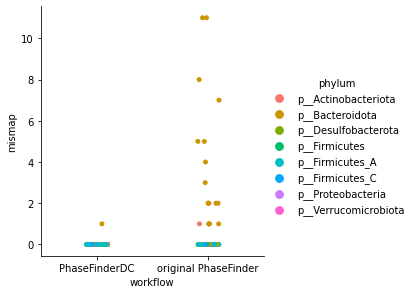

In [17]:
phasefinderOrigVsDCComparisonDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS3.csv.gz'))
phasefinderOrigVsDCComparisonDf['mismap']=phasefinderOrigVsDCComparisonDf.actualStrain!=phasefinderOrigVsDCComparisonDf.mappedStrain
phasefinderOrigVsDCComparisonDf['mismap']=phasefinderOrigVsDCComparisonDf.actualStrain!=phasefinderOrigVsDCComparisonDf.mappedStrain

g=sns.catplot(kind='strip',hue='phylum',y='mismap',x='workflow',
                  palette=ggtreeCmap,hue_order=np.sort(strainDf.phylum.unique()),
                  aspect=.95,height=4,
                  data=phasefinderOrigVsDCComparisonDf.groupby(['actualStrain','workflow'])['mismap'].sum().reset_index().merge(strainDf[['Strain','phylum']].rename(columns={'Strain':'actualStrain'})))
g.savefig(os.path.join(workingDir,'figures','phasefinderOrigComparePlot.pdf'))


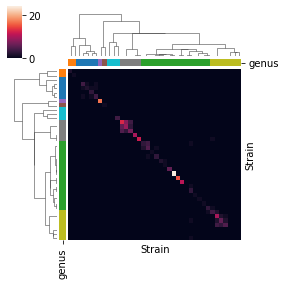

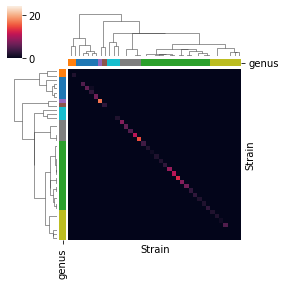

In [22]:
bacteroidesStrains=strainDf[strainDf.phylum=='p__Bacteroidota'].Strain.unique()
phasefinderOrigInvertonsMatDf=phasefinderOrigVsDCComparisonDf[phasefinderOrigVsDCComparisonDf.workflow=='original PhaseFinder'].groupby(['mappedStrain','actualStrain'])['ID'].count().unstack().reindex(strainDf.Strain).reindex(strainDf.Strain,axis=1).fillna(0).replace(-np.inf,0)
phasefinderOrigInvertonsMatDf=phasefinderOrigInvertonsMatDf.loc[bacteroidesStrains,bacteroidesStrains]
g=sns.clustermap(phasefinderOrigInvertonsMatDf,
                 vmin=0,vmax=24,
               row_colors=rowColorsFromCatSeries(strainDf.loc[strainDf.phylum=='p__Bacteroidota',['Strain','genus']].set_index('Strain')['genus'],cmap='tab10')[0],
               col_colors=rowColorsFromCatSeries(strainDf.loc[strainDf.phylum=='p__Bacteroidota',['Strain','genus']].set_index('Strain')['genus'],cmap='tab10')[0],
               row_linkage=linkageFromDistDf(phyloDistDf.loc[phasefinderOrigInvertonsMatDf.index,phasefinderOrigInvertonsMatDf.index]),
               col_linkage=linkageFromDistDf(phyloDistDf.loc[phasefinderOrigInvertonsMatDf.columns,phasefinderOrigInvertonsMatDf.columns]),
                xticklabels=0, yticklabels=0,
               figsize=(4,4),
                dendrogram_ratio=[0.2,0.2])
g.savefig(os.path.join(workingDir,'figures','phasefinderOrigBacteroidotaHeatmap.pdf'))


phasefinderDCInvertonsMatDf=phasefinderOrigVsDCComparisonDf[phasefinderOrigVsDCComparisonDf.workflow=='PhaseFinderDC'].groupby(['mappedStrain','actualStrain'])['ID'].count().unstack().reindex(strainDf.Strain).reindex(strainDf.Strain,axis=1).fillna(0).replace(-np.inf,0)
phasefinderDCInvertonsMatDf=phasefinderDCInvertonsMatDf.loc[bacteroidesStrains,bacteroidesStrains]
g=sns.clustermap(phasefinderDCInvertonsMatDf,
                 vmin=0,vmax=24,
               row_colors=rowColorsFromCatSeries(strainDf.loc[strainDf.phylum=='p__Bacteroidota',['Strain','genus']].set_index('Strain')['genus'],cmap='tab10')[0],
               col_colors=rowColorsFromCatSeries(strainDf.loc[strainDf.phylum=='p__Bacteroidota',['Strain','genus']].set_index('Strain')['genus'],cmap='tab10')[0],
               row_linkage=linkageFromDistDf(phyloDistDf.loc[phasefinderDCInvertonsMatDf.index,phasefinderDCInvertonsMatDf.index]),
               col_linkage=linkageFromDistDf(phyloDistDf.loc[phasefinderDCInvertonsMatDf.columns,phasefinderDCInvertonsMatDf.columns]),
                xticklabels=0, yticklabels=0,
               figsize=(4,4),
                dendrogram_ratio=[0.2,0.2])
g.savefig(os.path.join(workingDir,'figures','phasefinderDCBacteroidotaHeatmap.pdf'))


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


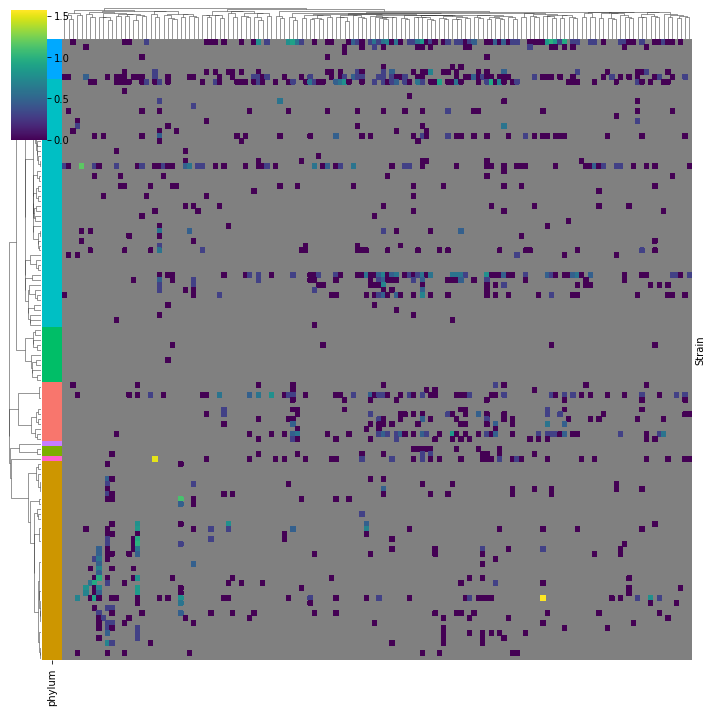

In [36]:
invertonInfoDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS5.csv.gz'))
invertonInfoDf['abbrev']=[ID.split('__')[0] for ID in invertonInfoDf['inverton ID']]
invertonInfoDf=invertonInfoDf.merge(strainDf[['Strain','abbrev','phylum']],on='abbrev')

invertonGroupDistDf=pd.read_csv(os.path.join(workingDir,'data','trees','invertonGroupDistDf.csv'),index_col=0)
invertonGroupDistMatDf=invertonGroupDistDf.set_index(['clusterInd1','clusterInd2'])['minDist'].unstack()
invertonGroupDistMatDf[invertonGroupDistMatDf<0]=0

invertonGroupCountDf=invertonInfoDf.groupby(['Strain','inverton group'])['inverton ID'].count().unstack().reset_index().merge(strainDf['Strain'],on='Strain',how='outer').set_index('Strain').fillna(0).astype('int')
logInvertonGroupCountDf=np.log10(invertonGroupCountDf)
logInvertonGroupCountDf.replace(-np.inf, np.nan, inplace=True)
g=sns.clustermap(logInvertonGroupCountDf,
               cmap='viridis',
                 row_colors=rowColorsFromCatSeries(strainDf[['Strain','phylum']].set_index('Strain')['phylum'],cmap=ggtreeCmap)[0],
               row_linkage=linkageFromDistDf(phyloDistDf.loc[invertonGroupCountDf.index,invertonGroupCountDf.index]),
               col_linkage=linkageFromDistDf(invertonGroupDistMatDf.loc[invertonGroupCountDf.columns,invertonGroupCountDf.columns]),
                xticklabels=0, yticklabels=0,figsize=(10,10),
                dendrogram_ratio=[0.05,0.05])
g.ax_heatmap.set_facecolor('grey')
g.savefig(os.path.join(workingDir,'figures','invertonStrainByGroupHeatmap.pdf'))



In [50]:
pgapBed=pybedtools.bedtool.BedTool(os.path.join(workingDir,'data','geneAnnotations','pgapStrandedAnnotations.bed')).sort()
invertaseDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS11.csv.gz'))

invertonInfoDf[['chrom','IRcoords']]=invertonInfoDf['inverton ID'].str.split(':',expand=True)
invertonInfoDf[['start_IR1','end_IR1','start_IR2','end_IR2']]=invertonInfoDf.IRcoords.str.split('-',expand=True).astype(int)
invertonInfoDf=invertonInfoDf.drop('IRcoords',axis=1)
invertonBedDf=invertonInfoDf[['chrom','start_IR1','end_IR2','inverton ID','inverton group']]
invertonBedDf['strand']='.'
invertonBed=pybedtools.BedTool.from_dataframe(invertonBedDf)


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
fimoDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS8.csv.gz'))
fimoBed=pybedtools.BedTool.from_dataframe(fimoDf[['chrom','start','end','motif ID','p-value','strand']])


In [63]:
def getStreamDf(motifsBed,pgapBed):
    bedMergeColumns=['chrom',
                     'start',
                     'end',
                     'name',
                     'score',
                     'strand',
                     'chrom_gene',
                     'start_gene',
                     'end_gene',
                     'name_gene',
                     'score_gene',
                     'strand_gene',
                    'dist']
    closestDf=motifsBed.closest(pgapBed,t='first',D='b').to_dataframe(names=bedMergeColumns)
    closestDf['motifUpstreamGene']=closestDf.dist<0
    closestDf['motifDownstreamGene']=closestDf.dist>0
    closestDf['motifOverlapGene']=closestDf.dist==0
    closestDf['sameStrand']=closestDf.strand_gene==closestDf.strand
    closestDf['sameStrandAndUpstream']=closestDf.sameStrand&closestDf.motifUpstreamGene
    closestDf['sameStrandAndDownstream']=closestDf.sameStrand&closestDf.motifDownstreamGene
    closestDf['oppoStrandAndUpstream']=~closestDf.sameStrand&closestDf.motifUpstreamGene
    closestDf['oppoStrandAndDownstream']=~closestDf.sameStrand&closestDf.motifDownstreamGene

    streamDf=closestDf.groupby('name')[['motifUpstreamGene','motifDownstreamGene','motifOverlapGene','sameStrand','sameStrandAndUpstream','sameStrandAndDownstream','oppoStrandAndUpstream','oppoStrandAndDownstream']].sum()
    return streamDf
streamDf=getStreamDf(fimoBed,pgapBed)

In [64]:
def getBootstrapDf(bootstrapStreamDfFile):
    bootstrapDf=pd.read_csv(bootstrapStreamDfFile)
    bootstrapDf['bootstrapInd']=int(os.path.basename(bootstrapStreamDfFile).split('streamDf')[1].split('.')[0])
    return bootstrapDf

def getBootstrapGtCompareDf(bootstrapStreamDfFile,streamDf):
    bootstrapDf=pd.read_csv(bootstrapStreamDfFile)

    compareColumns=['motifUpstreamGene',
           'motifDownstreamGene',
                    'motifOverlapGene',
                    'sameStrandAndUpstream',
           'sameStrandAndDownstream',
           'oppoStrandAndUpstream',
           'oppoStrandAndDownstream']
    streamDf2=streamDf.copy()
    for col in compareColumns:
        for compareType in ['_motifShuffled','_randMotifStrand','_randGeneStrand']:
            streamDf2[col+compareType]=streamDf2[col]
    gtCompareDf=None
    for compareType in ['_motifShuffled','_randMotifStrand','_randGeneStrand']:
        if gtCompareDf is None:
            gtCompareDf=(streamDf2[[col+compareType for col in compareColumns]]>bootstrapDf.set_index('name')[[col+compareType for col in compareColumns]])
        else:
            gtCompareDf=gtCompareDf.join(streamDf2[[col+compareType for col in compareColumns]]>bootstrapDf.set_index('name')[[col+compareType for col in compareColumns]])
    gtCompareDf=gtCompareDf.reset_index()

    return gtCompareDf

bootstrapStreamDfFiles=glob(os.path.join(workingDir,'data','motifGeneOrientationBootstrap','streamDf*.csv.gz'))

gtCompareConcatDf=pd.concat([getBootstrapGtCompareDf(file,streamDf) for file in bootstrapStreamDfFiles])
gtCountDf=gtCompareConcatDf.groupby('name').sum()

In [152]:
oppoUpCols=[col for col in gtCountDf.columns if 'pstream' in col and 'same' not in col and 'motifUpstreamGene_randMotifStrand' not in col]
oppoDownCols=[col for col in gtCountDf.columns if 'nstream' in col and 'same' not in col and 'motifDownstreamGene_randMotifStrand' not in col]
sameUpCols=[col for col in gtCountDf.columns if 'pstream' in col and 'oppo' not in col and 'motifUpstreamGene_randMotifStrand' not in col]
sameDownCols=[col for col in gtCountDf.columns if 'nstream' in col and 'oppo' not in col and 'motifDownstreamGene_randMotifStrand' not in col]
bootstrapThresh=9990

revCompUpstreamMotifs=list(streamDf[pd.concat([(gtCountDf[col]>bootstrapThresh) for col in oppoUpCols],axis=1).product(axis=1)==1].index)
inStrandUpstreamMotifs=list(streamDf[pd.concat([(gtCountDf[col]>bootstrapThresh) for col in sameUpCols],axis=1).product(axis=1)==1].index)

revCompDownstreamMotifs=list(streamDf[pd.concat([(gtCountDf[col]>bootstrapThresh) for col in oppoDownCols],axis=1).product(axis=1)==1].index)
inStrandDownstreamMotifs=list(streamDf[pd.concat([(gtCountDf[col]>bootstrapThresh) for col in sameDownCols],axis=1).product(axis=1)==1].index)

upstreamMotifDf=pd.DataFrame((revCompUpstreamMotifs+inStrandUpstreamMotifs,len(revCompUpstreamMotifs)*[False]+len(inStrandUpstreamMotifs)*[True])).T
upstreamMotifDf.columns=['motif ID','motifOnGeneStrand']

downstreamMotifDf=pd.DataFrame((revCompDownstreamMotifs+inStrandDownstreamMotifs,len(revCompDownstreamMotifs)*[False]+len(inStrandDownstreamMotifs)*[True])).T
downstreamMotifDf.columns=['motif ID','motifOnGeneStrand']


upstreamMotifDf['positionWrtGene']='upstream'
downstreamMotifDf['positionWrtGene']='downstream'
enrichMotifDf=pd.concat([upstreamMotifDf,downstreamMotifDf]).reset_index(drop=True)
enrichMotifDf

,motif ID,motifOnGeneStrand,positionWrtGene
0,126-2,False,upstream
1,136-2,False,upstream
2,143-2,False,upstream
3,68-2,False,upstream
4,126-8,True,upstream
5,131-2,True,upstream
6,131-5,True,upstream
7,62-1,True,upstream
8,3-1,False,downstream
9,51-2,False,downstream


In [138]:
motifClosestGeneDf=fimoBed.sort().closest(pgapBed.sort()).to_dataframe()
motifClosestGeneDf.columns=['chrom_motif','start_motif','end_motif','name_motif','score_motif','strand_motif',
                              'chrom_gene','start_gene','end_gene','name_gene','score_gene','strand_gene',]
motifClosestGeneDf['upstream']=motifClosestGeneDf.end_motif<=motifClosestGeneDf.start_gene
motifClosestGeneDf['downstream']=motifClosestGeneDf.end_gene<=motifClosestGeneDf.start_motif
motifClosestGeneDf['samestrand']=motifClosestGeneDf.strand_gene==motifClosestGeneDf.strand_motif
motifClosestGeneDf['plusStrandPromoter']=(motifClosestGeneDf.strand_motif=='+')
motifClosestGeneDf['putativePromoter']=(motifClosestGeneDf.samestrand)&((motifClosestGeneDf.upstream&motifClosestGeneDf.plusStrandPromoter)|(motifClosestGeneDf.downstream&~motifClosestGeneDf.plusStrandPromoter))
motifClosestGeneDf['geneFacingPromoter']=((motifClosestGeneDf.upstream)&(motifClosestGeneDf.strand_gene=='-'))|((motifClosestGeneDf.downstream)&(motifClosestGeneDf.strand_gene=='+'))
motifClosestGeneDf['motifInGene']=(~motifClosestGeneDf.upstream&~motifClosestGeneDf.downstream)

motifClosestGeneDfInvertonSubset=pybedtools.BedTool.from_dataframe(motifClosestGeneDf).intersect(invertonBed.sort(),f=1,wo=True).to_dataframe(disable_auto_names=True, header=None)
motifClosestGeneDfInvertonSubset=motifClosestGeneDfInvertonSubset.iloc[:,[0,1,2,22]]
motifClosestGeneDfInvertonSubset.columns=['chrom_motif','start_motif','end_motif','name_inverton']
motifClosestGeneDfInvertonSubset=motifClosestGeneDfInvertonSubset.merge(invertonInfoDf[['inverton ID','inverton group','intersectGene','chrom','start_IR1','end_IR1','start_IR2','end_IR2']].rename(columns={'inverton ID':'name_inverton'}),on='name_inverton')
motifClosestGeneDf=motifClosestGeneDf.merge(motifClosestGeneDfInvertonSubset,on=['chrom_motif','start_motif','end_motif'],how='left')
motifClosestGeneDf['abbrev']=[chrom.split('__')[0] for chrom in motifClosestGeneDf.chrom_motif]
motifClosestGeneDf=motifClosestGeneDf.merge(strainDf[['abbrev','Strain','species','phylum']],on='abbrev')
motifClosestGeneDf

,chrom_motif,start_motif,end_motif,name_motif,score_motif,strand_motif,chrom_gene,start_gene,end_gene,name_gene,score_gene,strand_gene,upstream,downstream,samestrand,plusStrandPromoter,putativePromoter,geneFacingPromoter,motifInGene,name_inverton,inverton group,intersectGene,chrom,start_IR1,end_IR1,start_IR2,end_IR2,abbrev,Strain,species,phylum
0,A-ca-DSM-14662__0,17264,17362,96-1,4.920000e-12,+,A-ca-DSM-14662__0,13410,14880,xylulokinase,12,+,False,True,True,True,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662,s__Anaerostipes caccae,p__Firmicutes_A
1,A-ca-DSM-14662__0,38828,38846,92-1,7.170000e-09,+,A-ca-DSM-14662__0,38277,39663,asparagine--tRNA ligase,40,+,False,False,True,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662,s__Anaerostipes caccae,p__Firmicutes_A
2,A-ca-DSM-14662__0,85113,85211,96-1,5.510000e-12,+,A-ca-DSM-14662__0,82407,82920,CvpA family protein,83,+,False,True,True,True,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662,s__Anaerostipes caccae,p__Firmicutes_A
3,A-ca-DSM-14662__0,98041,98109,131-5,7.440000e-09,+,A-ca-DSM-14662__0,96197,100277,SpaA isopeptide-forming pilin-related protein,101,+,False,False,True,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662,s__Anaerostipes caccae,p__Firmicutes_A
4,A-ca-DSM-14662__0,152462,152490,42-1,8.400000e-10,+,A-ca-DSM-14662__0,152025,153015,hydroxyacid dehydrogenase,156,+,False,False,True,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662,s__Anaerostipes caccae,p__Firmicutes_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42087,V-sp-6-1-27__0,1940098,1940153,137-5,4.080000e-09,-,V-sp-6-1-27__0,1940159,1940993,metallophosphoesterase,1774,+,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V-sp-6-1-27,Veillonella-sp-6-1-27,s__Veillonella parvula_A,p__Firmicutes_C
42088,V-sp-6-1-27__0,1970458,1970497,131-9,1.270000e-09,+,V-sp-6-1-27__0,1970186,1970633,50S ribosomal protein L9,1796,-,False,False,False,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V-sp-6-1-27,Veillonella-sp-6-1-27,s__Veillonella parvula_A,p__Firmicutes_C
42089,V-sp-6-1-27__0,2120117,2120146,4-1,7.000000e-09,+,V-sp-6-1-27__0,2119803,2120202,DUF805 domain-containing protein,1931,-,False,False,False,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V-sp-6-1-27,Veillonella-sp-6-1-27,s__Veillonella parvula_A,p__Firmicutes_C
42090,V-sp-6-1-27__0,2130490,2130545,122-3,4.540000e-09,+,V-sp-6-1-27__0,2129097,2131116,TM1812 family CRISPR-associated protein,1934,+,False,False,True,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V-sp-6-1-27,Veillonella-sp-6-1-27,s__Veillonella parvula_A,p__Firmicutes_C


In [142]:
promoterClosestGeneDf=motifClosestGeneDf.merge(upstreamMotifDf.rename(columns={'motif ID':'name_motif'}),on='name_motif')
promoterClosestGeneDf['strand_promoter']=['+' if (motifOnGeneStrand and strand_motif=='+')or(not motifOnGeneStrand and strand_motif=='-') else '-' for motifOnGeneStrand,strand_motif in zip(promoterClosestGeneDf.motifOnGeneStrand,promoterClosestGeneDf.strand_motif)]

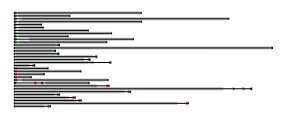

In [143]:
putativePromoterCount=0
maxLen=0
gd_diagram = GenomeDiagram.Diagram("Closest gene to motifs")
plotDf=promoterClosestGeneDf[(promoterClosestGeneDf.name_motif=='131-2')&(promoterClosestGeneDf.abbrev=='B-th-VPI-5482')]
plotDf=plotDf.sort_values(by=['putativePromoter','motifInGene','geneFacingPromoter','upstream'],ascending=False)
plotDf=plotDf.sort_values(by=['putativePromoter','motifInGene','upstream','strand_motif','strand_gene'],ascending=False)

for row in plotDf.iterrows():
    start=np.nanmin([row[1].start_motif,row[1].start_gene,row[1].start_IR1])-5
    end=np.nanmax([row[1].end_motif,row[1].end_gene,row[1].end_IR2])+5
    maxLen=np.max([maxLen,end-start])
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    if np.isnan(row[1].start_IR1):
        features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start_motif, row[1].end_motif), strand=int(f"{row[1].strand_promoter}1"),type="motifhit",id='motif'),
                  SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start_gene, row[1].end_gene), strand=int(f"{row[1].strand_gene}1"),type="gene",id=row[1].name_gene)]
    else:
        features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start_motif, row[1].end_motif), strand=int(f"{row[1].strand_promoter}1"),type="motifhit",id='motif'),
                  SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start_gene, row[1].end_gene), strand=int(f"{row[1].strand_gene}1"),type="gene",id=row[1].name_gene),
                 SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
                 SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    features=[shiftFeature(feature,start) for feature in features]
    
    for feature in features:
        if feature.type=='motifhit':
            if row[1].putativePromoter:
                color=Color(0,.5,0,0.5)
                putativePromoterCount+=1
            else:
                color=Color(1,0,.2,0.5)
        elif feature.type=='gene':
            color=Color(.6,.6,.6,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = ""#feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)
gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                fragments=1)
gd_diagram.write(os.path.join(workingDir,'figures','promoter131-2GeneBthExamples.png'), "png")
gd_diagram.write(os.path.join(workingDir,'figures','promoter131-2GeneBthExamples.svg'), "svg")
Image(filename=os.path.join(workingDir,'figures','promoter131-2GeneBthExamples.png')) 


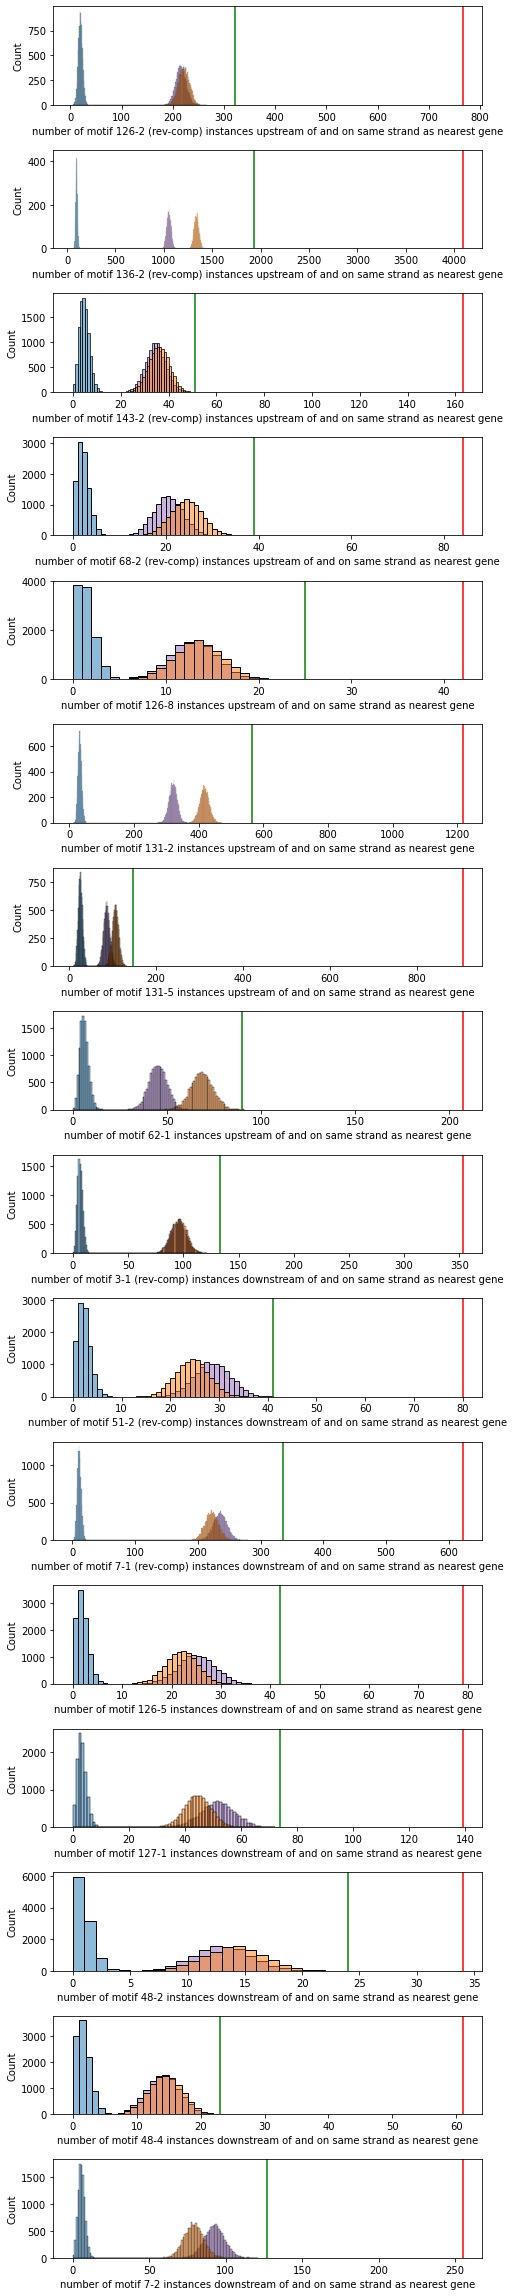

In [154]:
bootstrapDf=pd.concat([getBootstrapDf(bootstrapStreamDfFile) for bootstrapStreamDfFile in bootstrapStreamDfFiles])

fig,axs=plt.subplots(nrows=len(enrichMotifDf),figsize=(7,2*len(enrichMotifDf)))

for row in enrichMotifDf.iterrows():
    motifName=row[1]['motif ID']
    if row[1].motifOnGeneStrand:
        if row[1].positionWrtGene=='upstream':
            motifExpectedEnrich='sameStrandAndUpstream'
        else:
            motifExpectedEnrich='sameStrandAndDownstream'
    else:
        if row[1].positionWrtGene=='upstream':
            motifExpectedEnrich='oppoStrandAndUpstream'
        else:
            motifExpectedEnrich='oppoStrandAndDownstream'
    bootstrapDfSubset=bootstrapDf[bootstrapDf['name']==motifName]

#             fig=plt.figure(figsize=(7,1.5))
    with sns.plotting_context("notebook",font_scale=1.7):
        g=sns.histplot(x='promoter-like instances',hue='level_1',binwidth=1,ax=axs[row[0]],legend=False,
                       palette=['#1f77b4','#ff7f0e','#9467bd'],
                     data=bootstrapDfSubset[[col for col in bootstrapDfSubset.columns if motifExpectedEnrich in col]].stack().reset_index().rename(columns={0:'promoter-like instances'}))
        if row[1].motifOnGeneStrand:
            if row[1].positionWrtGene=='upstream':
                g.set_xlabel(f'number of motif {motifName} instances upstream of and on same strand as nearest gene')
            else:
                g.set_xlabel(f'number of motif {motifName} instances downstream of and on same strand as nearest gene')
        else:
            if row[1].positionWrtGene=='upstream':
                g.set_xlabel(f'number of motif {motifName} (rev-comp) instances upstream of and on same strand as nearest gene')
            else:
                g.set_xlabel(f'number of motif {motifName} (rev-comp) instances downstream of and on same strand as nearest gene')
        g.axvline(streamDf.loc[motifName,motifExpectedEnrich],color='green')
        g.axvline(streamDf.loc[motifName,['motifUpstreamGene','motifDownstreamGene','motifOverlapGene']].sum(),color='red')
plt.tight_layout()
fig.savefig(os.path.join(workingDir,'figures','allEnrichedMotifsShuffle.pdf'))


In [185]:
allSubsetNearbyGeneCountDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS10.csv.gz'))

/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCo

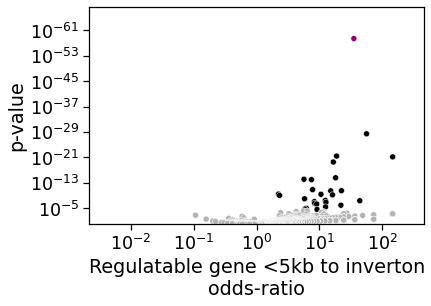

In [182]:
highlightGene='UpxY family transcription antiterminator'
plotDf=floorLogNearbyGeneCountDf(allSubsetNearbyGeneCountDf[(allSubsetNearbyGeneCountDf['inverton group']=='all')&(allSubsetNearbyGeneCountDf['nearby type']=='regulatable')])
plotDf['hue']=[description if description==highlightGene else str(sig) for sig,description in zip(plotDf.sig, plotDf['gene annotation'])]
plotDf['logOddsRatio']=np.log10(plotDf['odds ratio'])

pvalFloor=np.nanmin(plotDf.loc[plotDf['p-value']>0,'p-value'])
lorCeil=np.nanmax(np.abs(plotDf.loc[np.isfinite(plotDf['logOddsRatio']),'logOddsRatio']))

with sns.plotting_context("notebook",font_scale=1.6):
    fig=plt.figure()
    g=sns.scatterplot(x='logOddsRatio',y='p-value',hue='hue',
                      hue_order=[highlightGene,'False','True'],
                      palette=[(.6,0,.4),(.7,.7,.7),(0,0,0)],legend=False,
                      data=plotDf)
    g.set_yscale('log')
    g.set_ylim([pvalFloor*1e-10,1])
    g.set_xlim([-lorCeil-.5,lorCeil+.5])
    g.invert_yaxis()
    g.set_ylabel('p-value')
    g.set_xlabel('Regulatable gene <5kb to inverton\nodds-ratio')
    fig.savefig(os.path.join(workingDir,'figures','regulatableGeneVolcanoPlot.pdf'))
    g.set_xticklabels([f"$10^{{{label.get_text()}}}$" for label in g.get_xticklabels()])
    fig.savefig(os.path.join(workingDir,'figures','regulatableGeneVolcanoPlot.pdf'))


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCo

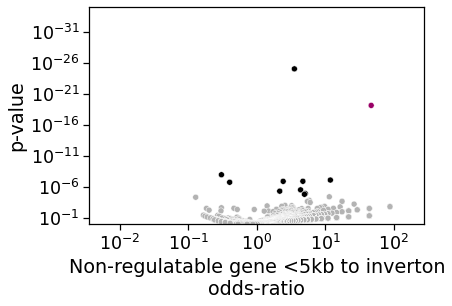

In [183]:
highlightGene='tyrosine-type DNA invertase cluster 3b'
plotDf=floorLogNearbyGeneCountDf(allSubsetNearbyGeneCountDf[(allSubsetNearbyGeneCountDf['inverton group']=='all')&(allSubsetNearbyGeneCountDf['nearby type']=='non-regulatable')])
plotDf['hue']=[description if description==highlightGene else str(sig) for sig,description in zip(plotDf.sig, plotDf['gene annotation'])]
plotDf['logOddsRatio']=np.log10(plotDf['odds ratio'])

pvalFloor=np.nanmin(plotDf.loc[plotDf['p-value']>0,'p-value'])
lorCeil=np.nanmax(np.abs(plotDf.loc[np.isfinite(plotDf['logOddsRatio']),'logOddsRatio']))

with sns.plotting_context("notebook",font_scale=1.6):
    fig=plt.figure()
    g=sns.scatterplot(x='logOddsRatio',y='p-value',hue='hue',
                      hue_order=[highlightGene,'False','True'],
                      palette=[(.6,0,.4),(.7,.7,.7),(0,0,0)],legend=False,
                      data=plotDf)
    g.set_yscale('log')
    g.set_ylim([pvalFloor*1e-10,1])
    g.set_xlim([-lorCeil-.5,lorCeil+.5])
    g.invert_yaxis()
    g.set_ylabel('p-value')
    g.set_xlabel('Non-regulatable gene <5kb to inverton\nodds-ratio')
    fig.savefig(os.path.join(workingDir,'figures','nonregulatableGeneVolcanoPlot.pdf'))
    g.set_xticklabels([f"$10^{{{label.get_text()}}}$" for label in g.get_xticklabels()])
    fig.savefig(os.path.join(workingDir,'figures','nonregulatableGeneVolcanoPlot.pdf'))


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCo

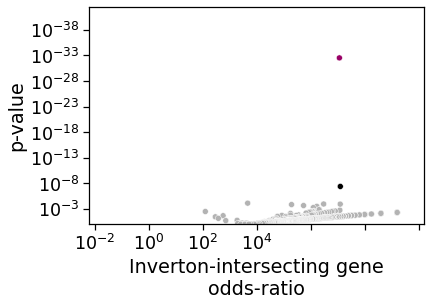

In [184]:
highlightGene='restriction endonuclease subunit S'
plotDf=floorLogNearbyGeneCountDf(allSubsetNearbyGeneCountDf[(allSubsetNearbyGeneCountDf['inverton group']=='all')&(allSubsetNearbyGeneCountDf['nearby type']=='inverton-intersecting')])
plotDf['hue']=[description if description==highlightGene else str(sig) for sig,description in zip(plotDf.sig, plotDf['gene annotation'])]
plotDf['logOddsRatio']=np.log10(plotDf['odds ratio'])

pvalFloor=np.nanmin(plotDf.loc[plotDf['p-value']>0,'p-value'])
lorCeil=np.nanmax(np.abs(plotDf.loc[np.isfinite(plotDf['logOddsRatio']),'logOddsRatio']))

with sns.plotting_context("notebook",font_scale=1.6):
    fig=plt.figure()
    g=sns.scatterplot(x='logOddsRatio',y='p-value',hue='hue',
                      hue_order=[highlightGene,'False','True'],
                      palette=[(.6,0,.4),(.7,.7,.7),(0,0,0)],legend=False,
                      data=plotDf)
    g.set_yscale('log')
    g.set_ylim([pvalFloor*1e-10,1])
    g.set_xlim([-lorCeil-.5,lorCeil+.5])
    g.invert_yaxis()
    g.set_ylabel('p-value')
    g.set_xlabel('Inverton-intersecting gene\nodds-ratio')
    fig.savefig(os.path.join(workingDir,'figures','invertonIntersectingGeneVolcanoPlot.pdf'))
    g.set_xticklabels([f"$10^{{{label.get_text()}}}$" for label in g.get_xticklabels()])
    fig.savefig(os.path.join(workingDir,'figures','invertonIntersectingGeneVolcanoPlot.pdf'))


In [197]:
bacteroidesInvertonPromoterClosestGeneDf=promoterClosestGeneDf[(~promoterClosestGeneDf['name_inverton'].isna())&(promoterClosestGeneDf['name_motif'].isin(['126-2','131-2','136-2']))]
bacteroidesInvertonPromoterClosestGeneDf['upstream']=bacteroidesInvertonPromoterClosestGeneDf.end_motif<=bacteroidesInvertonPromoterClosestGeneDf.start_gene
bacteroidesInvertonPromoterClosestGeneDf['downstream']=bacteroidesInvertonPromoterClosestGeneDf.end_gene<=bacteroidesInvertonPromoterClosestGeneDf.start_motif
bacteroidesInvertonPromoterClosestGeneDf['samestrand']=bacteroidesInvertonPromoterClosestGeneDf.strand_gene!=bacteroidesInvertonPromoterClosestGeneDf.strand_motif
bacteroidesInvertonPromoterClosestGeneDf['plusStrandPromoter']=bacteroidesInvertonPromoterClosestGeneDf.strand_motif=='+'
bacteroidesInvertonPromoterClosestGeneDf['putativePromoter']=(bacteroidesInvertonPromoterClosestGeneDf.samestrand)&((bacteroidesInvertonPromoterClosestGeneDf.upstream&bacteroidesInvertonPromoterClosestGeneDf.plusStrandPromoter)|(bacteroidesInvertonPromoterClosestGeneDf.downstream&~bacteroidesInvertonPromoterClosestGeneDf.plusStrandPromoter))
bacteroidesInvertonPromoterClosestGeneDf['geneFacingPromoter']=((bacteroidesInvertonPromoterClosestGeneDf.upstream)&(bacteroidesInvertonPromoterClosestGeneDf.strand_gene=='-'))|((bacteroidesInvertonPromoterClosestGeneDf.downstream)&(bacteroidesInvertonPromoterClosestGeneDf.strand_gene=='+'))
bacteroidesInvertonPromoterClosestGeneDf['motifInGene']=(~bacteroidesInvertonPromoterClosestGeneDf.upstream&~bacteroidesInvertonPromoterClosestGeneDf.downstream)
bacteroidesInvertonPromoterClosestGeneDf=bacteroidesInvertonPromoterClosestGeneDf.sort_values(by=['putativePromoter','motifInGene','geneFacingPromoter','upstream'],ascending=False)
bacteroidesInvertonPromoterClosestGeneDf=bacteroidesInvertonPromoterClosestGeneDf.sort_values(by=['motifInGene','upstream','strand_motif','strand_gene'],ascending=False)
bacteroidesInvertonPromoterClosestGeneDf=bacteroidesInvertonPromoterClosestGeneDf.drop_duplicates(subset='name_inverton')

/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is 

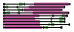

In [196]:
maxLen=0
gd_diagram = GenomeDiagram.Diagram("Closest gene to motifs")
plotDf=bacteroidesInvertonPromoterClosestGeneDf[bacteroidesInvertonPromoterClosestGeneDf.name_gene=='UpxY family transcription antiterminator']
for row in plotDf.iterrows():
    start=np.min([row[1].start_motif,row[1].start_gene,row[1].start_IR1])-5
    end=np.max([row[1].end_motif,row[1].end_gene,row[1].end_IR2])+5
    maxLen=np.max([maxLen,end-start])
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start_motif, row[1].end_motif), strand=int(f"{row[1].strand_promoter}1"),type="motifhit",id='motif'),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start_gene, row[1].end_gene), strand=int(f"{row[1].strand_promoter}1"),type="gene",id=row[1].name_gene),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    features=[shiftFeature(feature,start) for feature in features]
    
    for feature in features:
        if feature.type=='motifhit':
            color=Color(0,.5,0,0.5)
        elif feature.type=='gene':
            color=Color(.6,0,.4,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = ""#feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)

gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                fragments=1)
gd_diagram.write(os.path.join(workingDir,'figures','IRpromoterGeneExampleUpxY.png'), "png")
gd_diagram.write(os.path.join(workingDir,'figures','IRpromoterGeneExampleUpxY.svg'), "svg")
Image(filename=os.path.join(workingDir,'figures','IRpromoterGeneExampleUpxY.png')) 


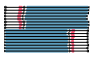

In [199]:
maxLen=0
gd_diagram = GenomeDiagram.Diagram("Closest gene to motifs")
plotDf=bacteroidesInvertonPromoterClosestGeneDf[bacteroidesInvertonPromoterClosestGeneDf.name_gene=='tyrosine-type DNA invertase cluster 3b']
for row in plotDf.iterrows():
    start=np.min([row[1].start_motif,row[1].start_gene,row[1].start_IR1])-5
    end=np.max([row[1].end_motif,row[1].end_gene,row[1].end_IR2])+5
    maxLen=np.max([maxLen,end-start])
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start_motif, row[1].end_motif), strand=int(f"{row[1].strand_promoter}1"),type="motifhit",id='motif'),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start_gene, row[1].end_gene), strand=int(f"{row[1].strand_promoter}1"),type="gene",id=row[1].name_gene),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    features=[shiftFeature(feature,start) for feature in features]
    
    for feature in features:
        if feature.type=='motifhit':
            color=Color(1,0,.2,0.5)
        elif feature.type=='gene':
            color=Color(0,.4,.6,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = ""#feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)

gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                fragments=1)
gd_diagram.write(os.path.join(workingDir,'figures','IRpromoterGeneExampleTTDI.png'), "png")
gd_diagram.write(os.path.join(workingDir,'figures','IRpromoterGeneExampleTTDI.svg'), "svg")
Image(filename=os.path.join(workingDir,'figures','IRpromoterGeneExampleTTDI.png')) 


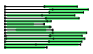

In [206]:
invertonGroup145Df=invertonBed.to_dataframe()
invertonGroup145Df=invertonGroup145Df[invertonGroup145Df.score==145]

invertonGroup145ClosestGeneDf=pybedtools.BedTool.from_dataframe(invertonGroup145Df[['chrom','start','end']]).sort().closest(pgapBed.sort()).to_dataframe()
invertonGroup145ClosestGeneDf=invertonGroup145ClosestGeneDf.set_index(['chrom','start','end']).join(invertonGroup145Df.set_index(['chrom','start','end']),lsuffix='_gene',rsuffix='_inverton').reset_index()
invertonGroup145ClosestGeneDf
invertonGroup145ClosestGeneDf.columns=['chrom_inverton','start_inverton','end_inverton',
                                                   'chrom_gene','start_gene','end_gene','name_gene','score_gene','strand_gene',
                                                   'name_inverton','score_inverton','strand_inverton',]
invertonGroup145ClosestGeneDf=invertonGroup145ClosestGeneDf.merge(invertonInfoDf[['Strain','inverton ID','inverton group','intersectGene','chrom','start_IR1','end_IR1','start_IR2','end_IR2']].rename(columns={'inverton ID':'name_inverton'}),
                                               on='name_inverton')
invertonGroup145ClosestGeneDf
invertonGroup145ClosestGeneDf=invertonGroup145ClosestGeneDf[['Strain','inverton group','chrom',
                                           'start_gene','end_gene','name_gene','score_gene','strand_gene',
                                           'start_inverton','end_inverton','name_inverton','score_inverton','strand_inverton',
                                           'start_IR1','end_IR1','start_IR2','end_IR2']]
invertonGroup145ClosestGeneDf=invertonGroup145ClosestGeneDf.sort_values(by=['strand_gene'],ascending=False)
invertonGroup145ClosestGeneDf=invertonGroup145ClosestGeneDf.drop_duplicates(subset='name_inverton')

maxLen=0
gd_diagram = GenomeDiagram.Diagram("Closest gene to motifs")
plotDf=invertonGroup145ClosestGeneDf[invertonGroup145ClosestGeneDf.name_gene=='restriction endonuclease subunit S']
for row in plotDf.iterrows():
    start=np.min([row[1].start_gene,row[1].start_inverton])-5
    end=np.max([row[1].end_gene,row[1].end_inverton])+5
    maxLen=np.max([maxLen,end-start])
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start_gene, row[1].end_gene), strand=int(f"{row[1].strand_gene}1"),type="gene",id=row[1].name_gene),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    features=[shiftFeature(feature,start) for feature in features]
    
    for feature in features:
        if feature.type=='motifhit':
            color=Color(1,0,.2,0.5)
        elif feature.type=='gene':
            color=Color(0,.9,.2,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = ""#feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)
gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                fragments=1)
gd_diagram.write(os.path.join(workingDir,'figures','IRintersectGeneExampleRESS145.png'), "png")
gd_diagram.write(os.path.join(workingDir,'figures','IRintersectGeneExampleRESS145.svg'), "svg")
Image(filename=os.path.join(workingDir,'figures','IRintersectGeneExampleRESS145.png')) 



/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


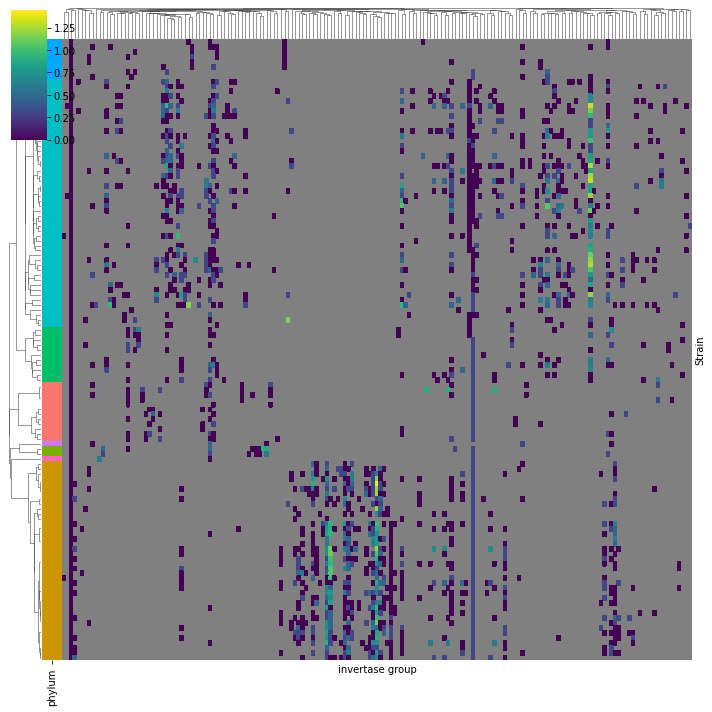

In [217]:
invertaseDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS11.csv.gz'))
invertaseDf['abbrev']=[chrom.split('__')[0] for chrom in invertaseDf['chrom']]
invertaseDf=invertaseDf.merge(strainDf[['Strain','abbrev']],on='abbrev')
invertaseCountDf=invertaseDf.groupby(['invertase group','Strain'])['geneID'].count().unstack().fillna(0).T
invertaseGroupDistDf=pd.read_csv(os.path.join(workingDir,'data','trees','invertaseGroupDistDf.csv'),index_col=0)
invertaseGroupDistDf=invertaseGroupDistDf.set_index(['invertaseClusterInd1','invertaseClusterInd2'])['minDist'].unstack()
invertaseGroupDistDf[invertaseGroupDistDf<0]=0


allInvertaseLogPresenceMatrixDf=np.log10(invertaseCountDf)
allInvertaseLogPresenceMatrixDf.replace(-np.inf, np.nan, inplace=True)
g=sns.clustermap(allInvertaseLogPresenceMatrixDf,
               cmap='viridis',
                 row_colors=rowColorsFromCatSeries(strainDf[['Strain','phylum']].set_index('Strain')['phylum'],cmap=ggtreeCmap)[0],
               row_linkage=linkageFromDistDf(phyloDistDf.loc[allInvertaseLogPresenceMatrixDf.index,allInvertaseLogPresenceMatrixDf.index]),
               col_linkage=linkageFromDistDf(invertaseGroupDistDf.loc[allInvertaseLogPresenceMatrixDf.columns,allInvertaseLogPresenceMatrixDf.columns]),
                xticklabels=0, yticklabels=0,figsize=(10,10),
                dendrogram_ratio=[0.05,0.05])
g.ax_heatmap.set_facecolor('grey')
g.savefig(os.path.join(workingDir,'figures','invertaseStrainByGroupHeatmap.pdf'))


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


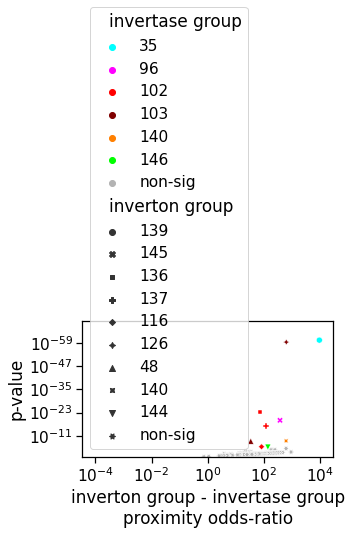

In [220]:
invertonInvertaseEnrichDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS12.csv.gz'))
invertonInvertaseEnrichDf['log odds ratio']=np.log10(invertonInvertaseEnrichDf['odds ratio'])
invertonInvertaseEnrichDf['inverton group']=[str(int(invertonGroup)) if sig else "non-sig" for invertonGroup,sig in zip(invertonInvertaseEnrichDf['inverton group'],invertonInvertaseEnrichDf.significant)]
invertonInvertaseEnrichDf['invertase group']=[str(int(invertaseGroup)) if sig else "non-sig" for invertaseGroup,sig in zip(invertonInvertaseEnrichDf['invertase group'],invertonInvertaseEnrichDf.significant)]
invertonInvertaseEnrichDf.sort_values(by='p-value')

pvalFloor=np.nanmin(invertonInvertaseEnrichDf.loc[invertonInvertaseEnrichDf['p-value']>0,'p-value'])
lorCeil=np.nanmax(np.abs(invertonInvertaseEnrichDf.loc[np.isfinite(invertonInvertaseEnrichDf['log odds ratio']),'log odds ratio']))

with sns.plotting_context("notebook",font_scale=1.4):
    fig=plt.figure(figsize=(4.5,2.5))
    g=sns.scatterplot(x='log odds ratio',y='p-value',style='inverton group',hue='invertase group',
                      hue_order=['35','96','102','103','140','146','non-sig'],
#                       style_order=['18','96','110','111','112','123','non-sig'],
                      style_order=['139','145','136','137','116','126','48','140','144','non-sig'],
#                       palette=[(.7,.7,.7),(0,0,0)],
                      palette=[(0,1,1),
                               (1,0,1),
                               (1,0,0),
                               (.5,0,0),
                               (1,.5,0),
                               (0,1,0),
                               (.7,.7,.7)],
                      legend='brief',
                      data=invertonInvertaseEnrichDf)
    g.set_yscale('log')
    g.set_ylim([pvalFloor*1e-10,1])
    g.set_xlim([-lorCeil-.5,lorCeil+.5])
    g.invert_yaxis()
    g.set_ylabel('p-value')
    g.set_xlabel('inverton group - invertase group\nproximity odds-ratio')
    fig.savefig(os.path.join(workingDir,'figures','invertonInvertaseEnrichVolcanoPlot.pdf'))
    g.set_xticklabels([f"$10^{{{label.get_text()}}}$" for label in g.get_xticklabels()])
    fig.savefig(os.path.join(workingDir,'figures','invertonInvertaseEnrichVolcanoPlot.pdf'))
    

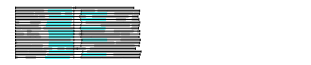

In [223]:
gd_diagram = GenomeDiagram.Diagram("invertase inverton")
maxLen=0
slopSize=2000
invertonGroup=139
invertaseGroup=35
plotDf=invertonInfoDf[invertonInfoDf['inverton group']==invertonGroup].drop_duplicates(subset='Strain')
for row in plotDf.iterrows():
    Strain_Name=row[1].chrom.split('__')[0]
    
    start=row[1].start_IR1-slopSize
    end=row[1].end_IR2+slopSize
    maxLen=np.max([maxLen,end-start])
    irBed=pybedtools.bedtool.BedTool(f"{row[1].chrom} {row[1].start_IR1} {row[1].end_IR2}",from_string=True)

    irFeatures=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    featuresDf=pgapBed.intersect(irBed.slop(b=slopSize,g=os.path.join(workingDir,'data','geneAnnotations','hCom2.chromsizes')),wa=True).to_dataframe()
    if len(featuresDf)>0:
        featuresDf=featuresDf.merge(invertaseDf.loc[invertaseDf['invertase group']==invertaseGroup,['chrom','start','end','invertase group']],on=['chrom','start','end'],how='left').fillna(-1)
        features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(featureRow[1].start), int(featureRow[1].end)), strand=int(f"{featureRow[1].strand}1"),type="gene",id=str(int(featureRow[1]['invertase group']))) for featureRow in featuresDf.iterrows()]
        features=features+irFeatures
    else:
        features=irFeatures
    features=[shiftFeature(feature,start) for feature in features]


    for feature in features:
        if feature.id==str(invertaseGroup):
            color=Color(0,1,1,0.5)
        elif feature.id=='-1':
            color=Color(.6,.6,.6,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = ""#feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)
gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                fragments=1)

gd_diagram.write(os.path.join(workingDir,'figures',f'invertaseGroup{invertaseGroup}InvertonGroup{invertonGroup}Example.png'), "png")
gd_diagram.write(os.path.join(workingDir,'figures',f'invertaseGroup{invertaseGroup}InvertonGroup{invertonGroup}Example.svg'), "svg")
Image(filename=os.path.join(workingDir,'figures',f'invertaseGroup{invertaseGroup}InvertonGroup{invertonGroup}Example.png')) 


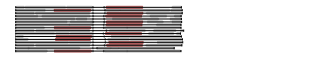

In [225]:
gd_diagram = GenomeDiagram.Diagram("invertase inverton")
maxLen=0
slopSize=2000
invertonGroup=126
invertaseGroup=103
plotDf=invertonInfoDf[invertonInfoDf['inverton group']==invertonGroup].drop_duplicates(subset='Strain')
for row in plotDf.iterrows():
    Strain_Name=row[1].chrom.split('__')[0]
    
    start=row[1].start_IR1-slopSize
    end=row[1].end_IR2+slopSize
    maxLen=np.max([maxLen,end-start])
    irBed=pybedtools.bedtool.BedTool(f"{row[1].chrom} {row[1].start_IR1} {row[1].end_IR2}",from_string=True)

    irFeatures=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    featuresDf=pgapBed.intersect(irBed.slop(b=slopSize,g=os.path.join(workingDir,'data','geneAnnotations','hCom2.chromsizes')),wa=True).to_dataframe()
    if len(featuresDf)>0:
        featuresDf=featuresDf.merge(invertaseDf.loc[invertaseDf['invertase group']==invertaseGroup,['chrom','start','end','invertase group']],on=['chrom','start','end'],how='left').fillna(-1)
        features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(featureRow[1].start), int(featureRow[1].end)), strand=int(f"{featureRow[1].strand}1"),type="gene",id=str(int(featureRow[1]['invertase group']))) for featureRow in featuresDf.iterrows()]
        features=features+irFeatures
    else:
        features=irFeatures
    features=[shiftFeature(feature,start) for feature in features]


    for feature in features:
        if feature.id==str(invertaseGroup):
            color=Color(.5,0,0,0.5)
        elif feature.id=='-1':
            color=Color(.6,.6,.6,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = ""#feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)
gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                fragments=1)

gd_diagram.write(os.path.join(workingDir,'figures',f'invertaseGroup{invertaseGroup}InvertonGroup{invertonGroup}Example.png'), "png")
gd_diagram.write(os.path.join(workingDir,'figures',f'invertaseGroup{invertaseGroup}InvertonGroup{invertonGroup}Example.svg'), "svg")
Image(filename=os.path.join(workingDir,'figures',f'invertaseGroup{invertaseGroup}InvertonGroup{invertonGroup}Example.png')) 


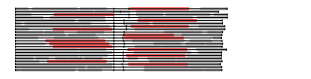

In [226]:
gd_diagram = GenomeDiagram.Diagram("invertase inverton")
maxLen=0
slopSize=2000
invertonGroup=136
invertaseGroup=102
plotDf=invertonInfoDf[invertonInfoDf['inverton group']==invertonGroup].drop_duplicates(subset='Strain')
for row in plotDf.iterrows():
    Strain_Name=row[1].chrom.split('__')[0]
    
    start=row[1].start_IR1-slopSize
    end=row[1].end_IR2+slopSize
    maxLen=np.max([maxLen,end-start])
    irBed=pybedtools.bedtool.BedTool(f"{row[1].chrom} {row[1].start_IR1} {row[1].end_IR2}",from_string=True)

    irFeatures=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    featuresDf=pgapBed.intersect(irBed.slop(b=slopSize,g=os.path.join(workingDir,'data','geneAnnotations','hCom2.chromsizes')),wa=True).to_dataframe()
    if len(featuresDf)>0:
        featuresDf=featuresDf.merge(invertaseDf.loc[invertaseDf['invertase group']==invertaseGroup,['chrom','start','end','invertase group']],on=['chrom','start','end'],how='left').fillna(-1)
        features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(featureRow[1].start), int(featureRow[1].end)), strand=int(f"{featureRow[1].strand}1"),type="gene",id=str(int(featureRow[1]['invertase group']))) for featureRow in featuresDf.iterrows()]
        features=features+irFeatures
    else:
        features=irFeatures
    features=[shiftFeature(feature,start) for feature in features]


    for feature in features:
        if feature.id==str(invertaseGroup):
            color=Color(1,0,0,0.5)
        elif feature.id=='-1':
            color=Color(.6,.6,.6,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = ""#feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)
gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                fragments=1)

gd_diagram.write(os.path.join(workingDir,'figures',f'invertaseGroup{invertaseGroup}InvertonGroup{invertonGroup}Example.png'), "png")
gd_diagram.write(os.path.join(workingDir,'figures',f'invertaseGroup{invertaseGroup}InvertonGroup{invertonGroup}Example.svg'), "svg")
Image(filename=os.path.join(workingDir,'figures',f'invertaseGroup{invertaseGroup}InvertonGroup{invertonGroup}Example.png')) 


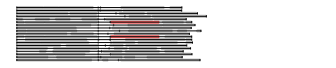

In [324]:
gd_diagram = GenomeDiagram.Diagram("invertase inverton")
maxLen=0
slopSize=2000
invertonGroup=131
invertaseGroup=102
plotDf=invertonInfoDf[invertonInfoDf['inverton group']==invertonGroup].drop_duplicates(subset='Strain')
for row in plotDf.iterrows():
    Strain_Name=row[1].chrom.split('__')[0]
    
    start=row[1].start_IR1-slopSize
    end=row[1].end_IR2+slopSize
    maxLen=np.max([maxLen,end-start])
    irBed=pybedtools.bedtool.BedTool(f"{row[1].chrom} {row[1].start_IR1} {row[1].end_IR2}",from_string=True)

    irFeatures=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    featuresDf=pgapBed.intersect(irBed.slop(b=slopSize,g=os.path.join(workingDir,'data','geneAnnotations','hCom2.chromsizes')),wa=True).to_dataframe()
    if len(featuresDf)>0:
        featuresDf=featuresDf.merge(invertaseDf.loc[invertaseDf['invertase group']==invertaseGroup,['chrom','start','end','invertase group']],on=['chrom','start','end'],how='left').fillna(-1)
        features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(featureRow[1].start), int(featureRow[1].end)), strand=int(f"{featureRow[1].strand}1"),type="gene",id=str(int(featureRow[1]['invertase group']))) for featureRow in featuresDf.iterrows()]
        features=features+irFeatures
    else:
        features=irFeatures
    features=[shiftFeature(feature,start) for feature in features]


    for feature in features:
        if feature.id==str(invertaseGroup):
            color=Color(1,0,0,0.5)
        elif feature.id=='-1':
            color=Color(.6,.6,.6,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = ""#feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)
gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                fragments=1)

gd_diagram.write(os.path.join(workingDir,'figures','invertaseGroup35InvertonGroup139Example.png'), "png")
gd_diagram.write(os.path.join(workingDir,'figures','invertaseGroup35InvertonGroup139Example.svg'), "svg")
Image(filename=os.path.join(workingDir,'figures','invertaseGroup35InvertonGroup139Example.png')) 


In [273]:
invertonDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS4.csv.gz'))
invertonDf=invertonDf.merge(sampleDf[['sample','sample type']])
invertonDf['abbrev']=[ID.split('__')[0] for ID in invertonDf['inverton ID']]
invertonDf=invertonDf.merge(strainDf[['Strain','abbrev']],on='abbrev')

invertonDf.head()

,inverton ID,sample,Pe_F,Pe_R,Pe_ratio,Span_F,Span_R,Span_ratio,sample type,abbrev,Strain
0,A-ca-DSM-14662__0:1004493-1004504-1004588-1004599,MB_P5R1a,4,0,0.0,2,0,0.0,in vitro mixed culture,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662
1,A-ca-DSM-14662__0:1478876-1478887-1479013-1479024,MB_P5R1a,4,0,0.0,2,0,0.0,in vitro mixed culture,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662
2,A-ca-DSM-14662__0:3206486-3206497-3206581-3206592,MB_P5R1a,2,0,0.0,1,0,0.0,in vitro mixed culture,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662
3,A-ca-DSM-14662__0:442585-442598-442691-442704,MB_P5R1a,6,0,0.0,3,0,0.0,in vitro mixed culture,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662
4,A-ca-DSM-14662__0:1004493-1004504-1004588-1004599,AS_P3R2c,12,0,0.0,6,0,0.0,in vitro mixed culture,A-ca-DSM-14662,Anaerostipes-caccae-DSM-14662


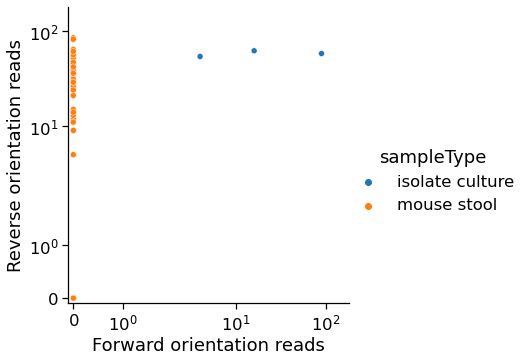

In [232]:
enrichInverton='B-th-VPI-5482__0:4315126-4315146-4315394-4315414'
plotDf=invertonDf[(invertonDf['inverton ID']==enrichInverton)&((invertonDf['sample'].str.contains('B6Gen'))|(invertonDf['sample'].str.contains('VPI-5482')))]
plotDf=plotDf[['sample','Pe_F','Pe_R']]
plotDf['sampleType']=['mouse stool' if 'B6Gen' in sampleID else 'isolate culture' for sampleID in plotDf['sample']]

with sns.plotting_context("notebook",font_scale=1.5):
    g=sns.relplot(x='Pe_F',y='Pe_R',hue='sampleType',data=plotDf,
                 hue_order=['isolate culture','mouse stool'],
                 palette='tab10',)
    #                  palette='viridis')
    lim=2*np.max([plotDf.Pe_F.max(),plotDf.Pe_R.max()])
    g.set(xscale="symlog")
    g.set(xlim=[-.1,lim])
    g.set(xlabel='Forward orientation reads')
    g.set(ylabel='Reverse orientation reads')

    g.set(yscale="symlog")
    g.set(ylim=[-.1,lim])
    g.savefig(os.path.join(workingDir,'figures','mouseIsolateComparisonFRscatter.pdf'))

In [265]:
invertonSumCountDf=invertonDf.groupby(['inverton ID','sample type'])[['Pe_F','Pe_R']].sum().unstack()
invertonSumCountDf.columns = [' '.join(col).strip() for col in invertonSumCountDf.columns.values]
invertonSumCountDf.drop(['Pe_F in vitro mixed culture','Pe_R in vitro mixed culture'],axis=1,inplace=True)


invertonSumCountDf[['odds ratio','p-value']]=[fisher_exact(np.asarray([[Pe_F_isolate,Pe_R_isolate],[Pe_F_mouse,Pe_R_mouse]])) for Pe_F_isolate,Pe_R_isolate,Pe_F_mouse,Pe_R_mouse in zip(invertonSumCountDf['Pe_F in vitro isolate culture'],
                                                                                                      invertonSumCountDf['Pe_R in vitro isolate culture'],
                                                                                                      invertonSumCountDf['Pe_F mouse stool'],
                                                                                                      invertonSumCountDf['Pe_R mouse stool'])]
invertonSumCountDf['sig']=invertonSumCountDf['p-value']<(0.05/len(invertonSumCountDf))
invertonSumCountDf.head()

,Pe_F in vitro isolate culture,Pe_F mouse stool,Pe_R in vitro isolate culture,Pe_R mouse stool,odds ratio,p-value,sig
inverton ID,,,,,,,
A-ca-DSM-14662__0:1004493-1004504-1004588-1004599,1234,436,0,0,NaN,1.000000e+00,False
A-ca-DSM-14662__0:1478876-1478887-1479013-1479024,2282,1338,0,1,inf,3.697874e-01,False
A-ca-DSM-14662__0:3206486-3206497-3206581-3206592,272,30,0,0,NaN,1.000000e+00,False
A-ca-DSM-14662__0:442585-442598-442691-442704,2963,1472,0,0,NaN,1.000000e+00,False
A-co-DSM-17241__0:3279180-3279202-3279415-3279437,1163,32,930,112,4.376882,4.124101e-15,True


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


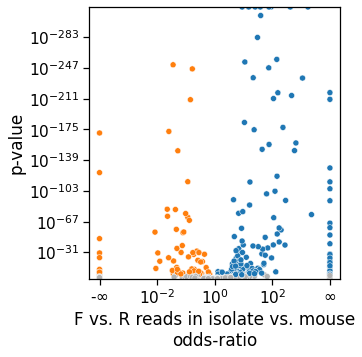

In [257]:
plotDf=invertonSumCountDf.copy()
plotDf['logOddsRatio']=np.log10(plotDf['odds ratio'])

pvalFloor=np.nanmin(plotDf.loc[plotDf['p-value']>0,'p-value'])
lorCeil=np.nanmax(np.abs(plotDf.loc[np.isfinite(plotDf['logOddsRatio']),'logOddsRatio']))
plotDf['p-value']=plotDf['p-value'].replace(0,pvalFloor*1e-10)
plotDf['logOddsRatio']=plotDf['logOddsRatio'].replace(np.inf,np.ceil(lorCeil)).replace(-np.inf,-np.ceil(lorCeil))

plotDf['hue']=['blue' if lor>0 else 'orange' for lor in plotDf['logOddsRatio']]
plotDf['hue']=[hue if sig else 'gray' for sig,hue in zip(plotDf.sig,plotDf.hue)]

with sns.plotting_context("notebook",font_scale=1.4):
    fig=plt.figure(figsize=(4.5,5))
    g=sns.scatterplot(x='logOddsRatio',y='p-value',hue='hue',
                      hue_order=['blue','orange','gray'],
                      palette=list(plt.get_cmap("tab10").colors[:2])+[(.7,.7,.7)],legend=False,
                      data=plotDf)
    g.set_yscale('log')
    g.set_ylim([pvalFloor*1e-10,1])
    g.set_xlim([-lorCeil-1,lorCeil+1])
    g.invert_yaxis()
    g.set_ylabel('p-value')
    g.set_xlabel('F vs. R reads in isolate vs. mouse\nodds-ratio')
    fig.savefig(os.path.join(workingDir,'figures','mouseIsolateBiasedInvertonVolcanoPlot.pdf'))
    xtl=[f"$10^{{{label.get_text()}}}$" for label in g.get_xticklabels()]
    xtl[1]="-$\infty$"
    xtl[-2]="$\infty$"
    g.set_xticklabels(xtl)
    fig.savefig(os.path.join(workingDir,'figures','mouseIsolateBiasedInvertonVolcanoPlot.pdf'))



/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


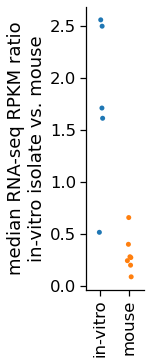

In [261]:
predictedGeneDf=pd.read_csv(os.path.join(workingDir,'data','supplementaryTables','TableS17.csv.gz'))
with sns.plotting_context("notebook",font_scale=1.5):
    g=sns.catplot(y='ratio',x='predicted upregulated condition',data=predictedGeneDf,
                 aspect=.2,height=5.2)
    g.set(ylabel="median RNA-seq RPKM ratio\nin-vitro isolate vs. mouse")
    g.set(xlabel="")
    g.set(xticklabels=["in-vitro","mouse"])
    g.set_xticklabels(rotation=90)
    g.savefig(os.path.join(workingDir,'figures','rnaseqValidation.pdf'))


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences

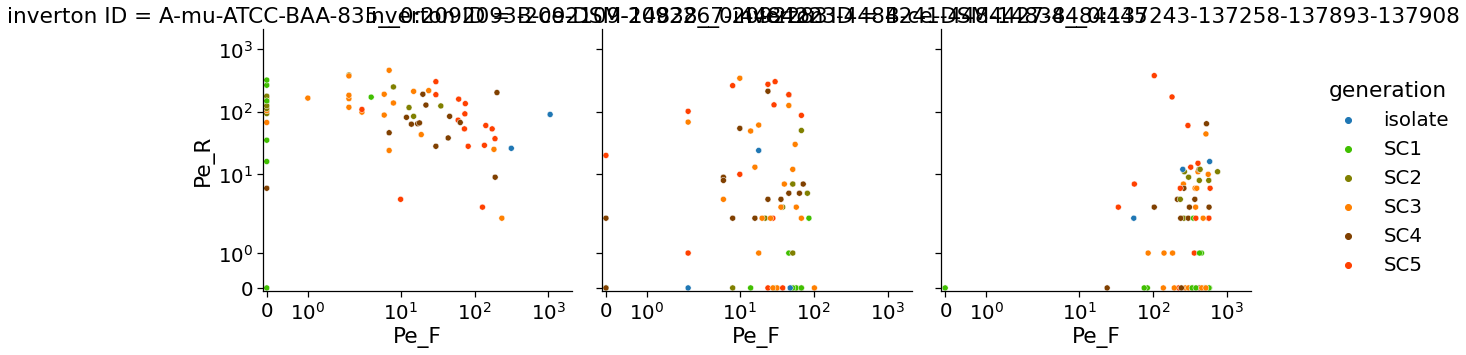

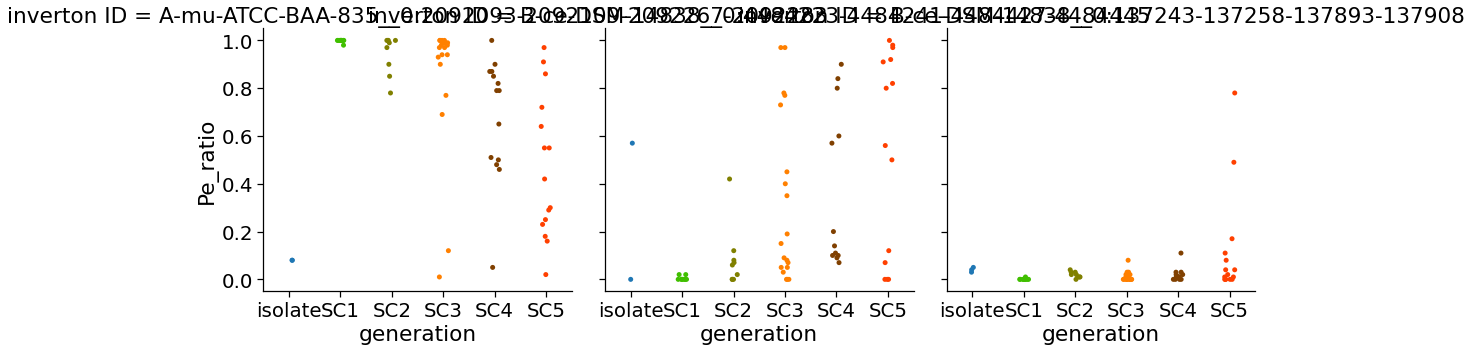

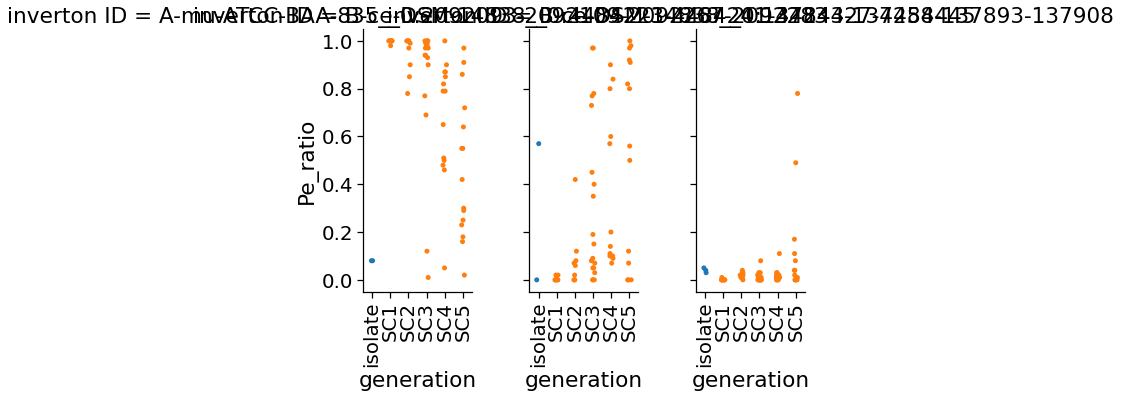

In [284]:
mousePlotInvertons=['A-mu-ATCC-BAA-835__0:2092093-2092109-2092267-2092283',
                   'B-ce-DSM-14838__0:4484223-4484241-4484427-4484445',
                   'B-ce-DSM-14838__0:137243-137258-137893-137908']

plotDf=invertonDf[(invertonDf['sample type']=='mouse stool')&(invertonDf['inverton ID'].isin(mousePlotInvertons))]

plotDf=plotDf.merge(sampleDf[['sample','description']])
plotDf['gender']=[description.split(': ')[-1].split(' ')[0] for description in plotDf.description]
plotDf['generation']=[description.split(' ')[-1] for description in plotDf.description]

plotDf2=invertonDf[(invertonDf.apply(lambda row: row['Strain'] in row['sample'], axis=1))&(invertonDf['inverton ID'].isin(mousePlotInvertons))]
plotDf2['generation']='isolate'
plotDf2['gender']='isolate'

plotDf=pd.concat([plotDf,plotDf2])
plotDf['Pe_tot']=plotDf['Pe_R']+plotDf['Pe_F']
with sns.plotting_context("notebook",font_scale=1.8):

    g=sns.relplot(x='Pe_F',y='Pe_R',hue='generation',col='inverton ID',
                  data=plotDf,
                  col_order=mousePlotInvertons,
                 hue_order=['isolate','SC1','SC2','SC3','SC4','SC5'],
                 palette=["#1f77b4",(.25,.75,0),(.5,.5,0),(1,.5,0),(.5,.25,0),(1,.25,0)],
                 )
    lim=2*np.max([plotDf.Pe_F.max(),plotDf.Pe_R.max()])
    g.set(xscale="symlog")
    g.set(xlim=[-.1,lim])

    g.set(yscale="symlog")
    g.set(ylim=[-.1,lim])
    g.savefig(os.path.join(workingDir,'figures','mouseDynamicInvertonsFRscatter.pdf'))

    g2=sns.catplot(y='Pe_ratio',x='generation',hue='generation',col='inverton ID',#dodge=False,
                  data=plotDf[plotDf.Pe_tot>=5],
                  col_order=mousePlotInvertons,
                  order=['isolate','SC1','SC2','SC3','SC4','SC5'],
                  hue_order=['isolate','SC1','SC2','SC3','SC4','SC5'],
                 palette=["#1f77b4",(.25,.75,0),(.5,.5,0),(1,.5,0),(.5,.25,0),(1,.25,0)],
                 )
    g2.savefig(os.path.join(workingDir,'figures','mouseDynamicInvertonsPeRatios.pdf'))

    g3=sns.catplot(y='Pe_ratio',x='generation',hue='generation',col='inverton ID',aspect=.5,#dodge=False,
                  data=plotDf[plotDf.Pe_tot>=5],
                  col_order=mousePlotInvertons,
                  order=['isolate','SC1','SC2','SC3','SC4','SC5'],
                  hue_order=['isolate','SC1','SC2','SC3','SC4','SC5'],
                 palette=["#1f77b4","#ff7f0e","#ff7f0e","#ff7f0e","#ff7f0e","#ff7f0e"],
                 )
    g3.set_xticklabels(rotation=90)
    g3.savefig(os.path.join(workingDir,'figures','mouseDynamicInvertonsPeRatios_narrow.pdf'))


/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences

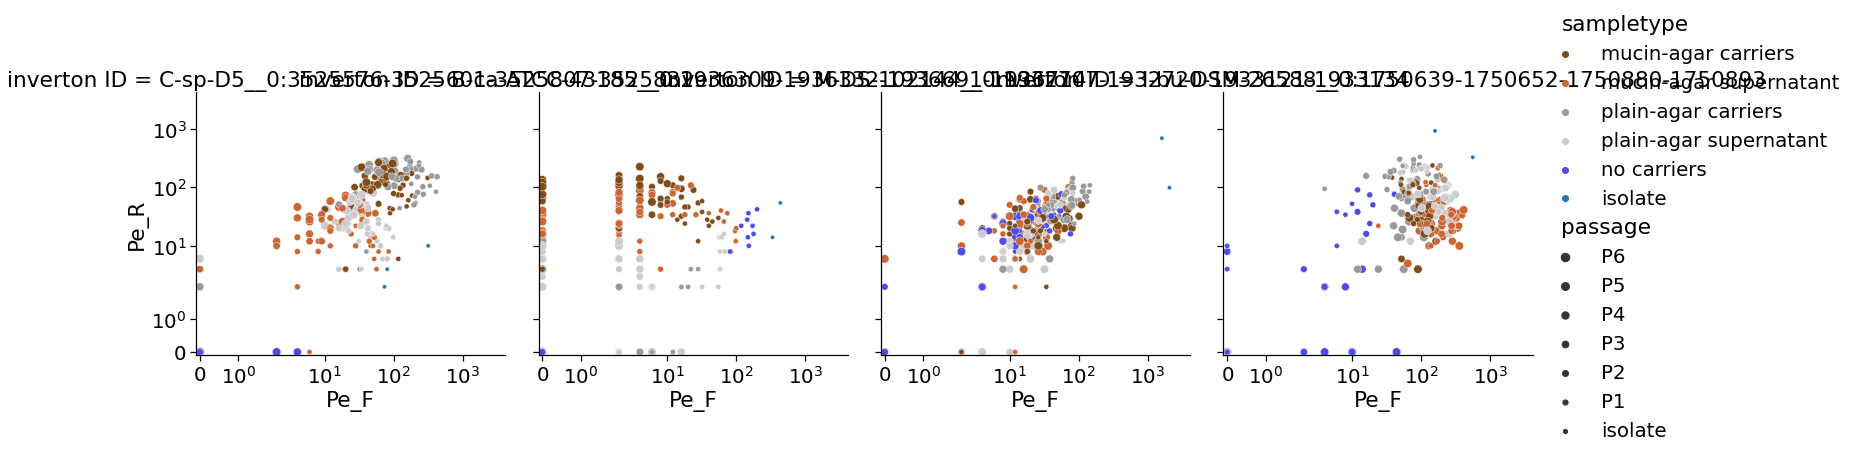

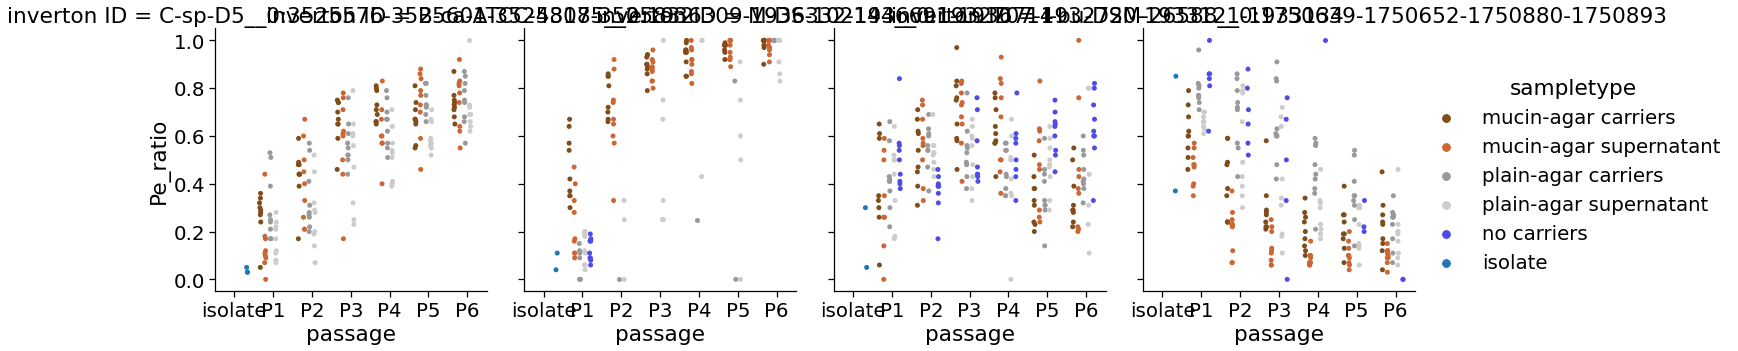

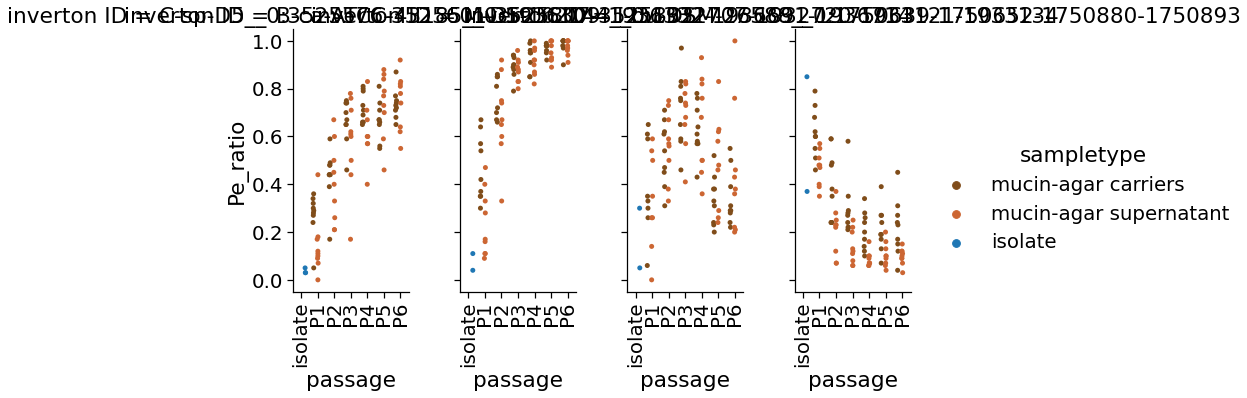

In [317]:
invitroPlotInvertons=['C-sp-D5__0:3525576-3525601-3525807-3525832',
                        'B-ca-ATCC-43185__0:1936309-1936332-1936691-1936714',
                        'M-DS-102144__0:1932707-1932720-1933121-1933134',
                     'I-bu-DSM-26588__0:1750639-1750652-1750880-1750893',]

plotDf=invertonDf[(invertonDf['sample type']=='in vitro mixed culture')&(invertonDf['sample'].str.contains('_P'))&(invertonDf['inverton ID'].isin(invitroPlotInvertons))]
plotDf=plotDf.merge(sampleDf[['sample','description']])
plotDf['passage']=[description.split('passage ')[-1].split(',')[0] for description in plotDf.description]
plotDf['sampletype']=[description.split('in vitro culture of ')[-1].split(', passage')[0] for description in plotDf.description]

plotDf2=invertonDf[(invertonDf.apply(lambda row: row['Strain'] in row['sample'], axis=1))&(invertonDf['inverton ID'].isin(invitroPlotInvertons))]
plotDf2['passage']='isolate'
plotDf2['sampletype']='isolate'

plotDf=pd.concat([plotDf,plotDf2])
plotDf['Pe_tot']=plotDf['Pe_R']+plotDf['Pe_F']

with sns.plotting_context("notebook",font_scale=1.8):
    
    g=sns.relplot(x='Pe_F',y='Pe_R',hue='sampletype',size='passage',col='inverton ID',
                  data=plotDf,
                  col_order=invitroPlotInvertons,
                 size_order=np.flip(['isolate','P1','P2','P3','P4','P5','P6']),
                 palette=[(0.5,0.3,0.1),(0.8,0.4,0.2),(0.6,0.6,0.6),(0.8,0.8,0.8),(0.3,0.3,0.9),"#1f77b4"],
                 hue_order=['mucin-agar carriers',
                            'mucin-agar supernatant',
                            'plain-agar carriers',
                            'plain-agar supernatant',
                            'no carriers',
                            'isolate']                 )#col_wrap=10)

    lim=2*np.max([plotDf.Pe_F.max(),plotDf.Pe_R.max()])
 
    g.set(xscale="symlog")
    g.set(xlim=[-.1,lim])

    g.set(yscale="symlog")
    g.set(ylim=[-.1,lim])
    g.savefig(os.path.join(workingDir,'figures','invitroDynamicInvertonsFRscatter.pdf'))


    g2=sns.catplot(y='Pe_ratio',x='passage',hue='sampletype',col='inverton ID',
                   dodge=True,
                  data=plotDf[plotDf.Pe_tot>=5],
                  col_order=invitroPlotInvertons,
                   aspect=.9,
                  order=['isolate','P1','P2','P3','P4','P5','P6'],
                 palette=[(0.5,0.3,0.1),(0.8,0.4,0.2),(0.6,0.6,0.6),(0.8,0.8,0.8),(0.3,0.3,0.9),"#1f77b4"],
                 hue_order=['mucin-agar carriers',
                            'mucin-agar supernatant',
                            'plain-agar carriers',
                            'plain-agar supernatant',
                            'no carriers',
                            'isolate']
                  )#col_wrap=10)

    g2.savefig(os.path.join(workingDir,'figures','invitroDynamicInvertonsPeRatios.pdf'))

    g3=sns.catplot(y='Pe_ratio',x='passage',hue='sampletype',col='inverton ID',
                   dodge=True,
                  data=plotDf[(plotDf.Pe_tot>=5)&(plotDf.sampletype.isin(['mucin-agar carriers','mucin-agar supernatant','isolate']))],
                  col_order=invitroPlotInvertons,
                   aspect=.5,
                  order=['isolate','P1','P2','P3','P4','P5','P6'],
                 palette=[(0.5,0.3,0.1),(0.8,0.4,0.2),"#1f77b4"],
                 hue_order=['mucin-agar carriers',
                            'mucin-agar supernatant',
                            'isolate']
                  )#col_wrap=10)

    g3.set_xticklabels(rotation=90)

    g3.savefig(os.path.join(workingDir,'figures','invitroDynamicInvertonsPeRatios_narrow.pdf'))



/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating

/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged ne

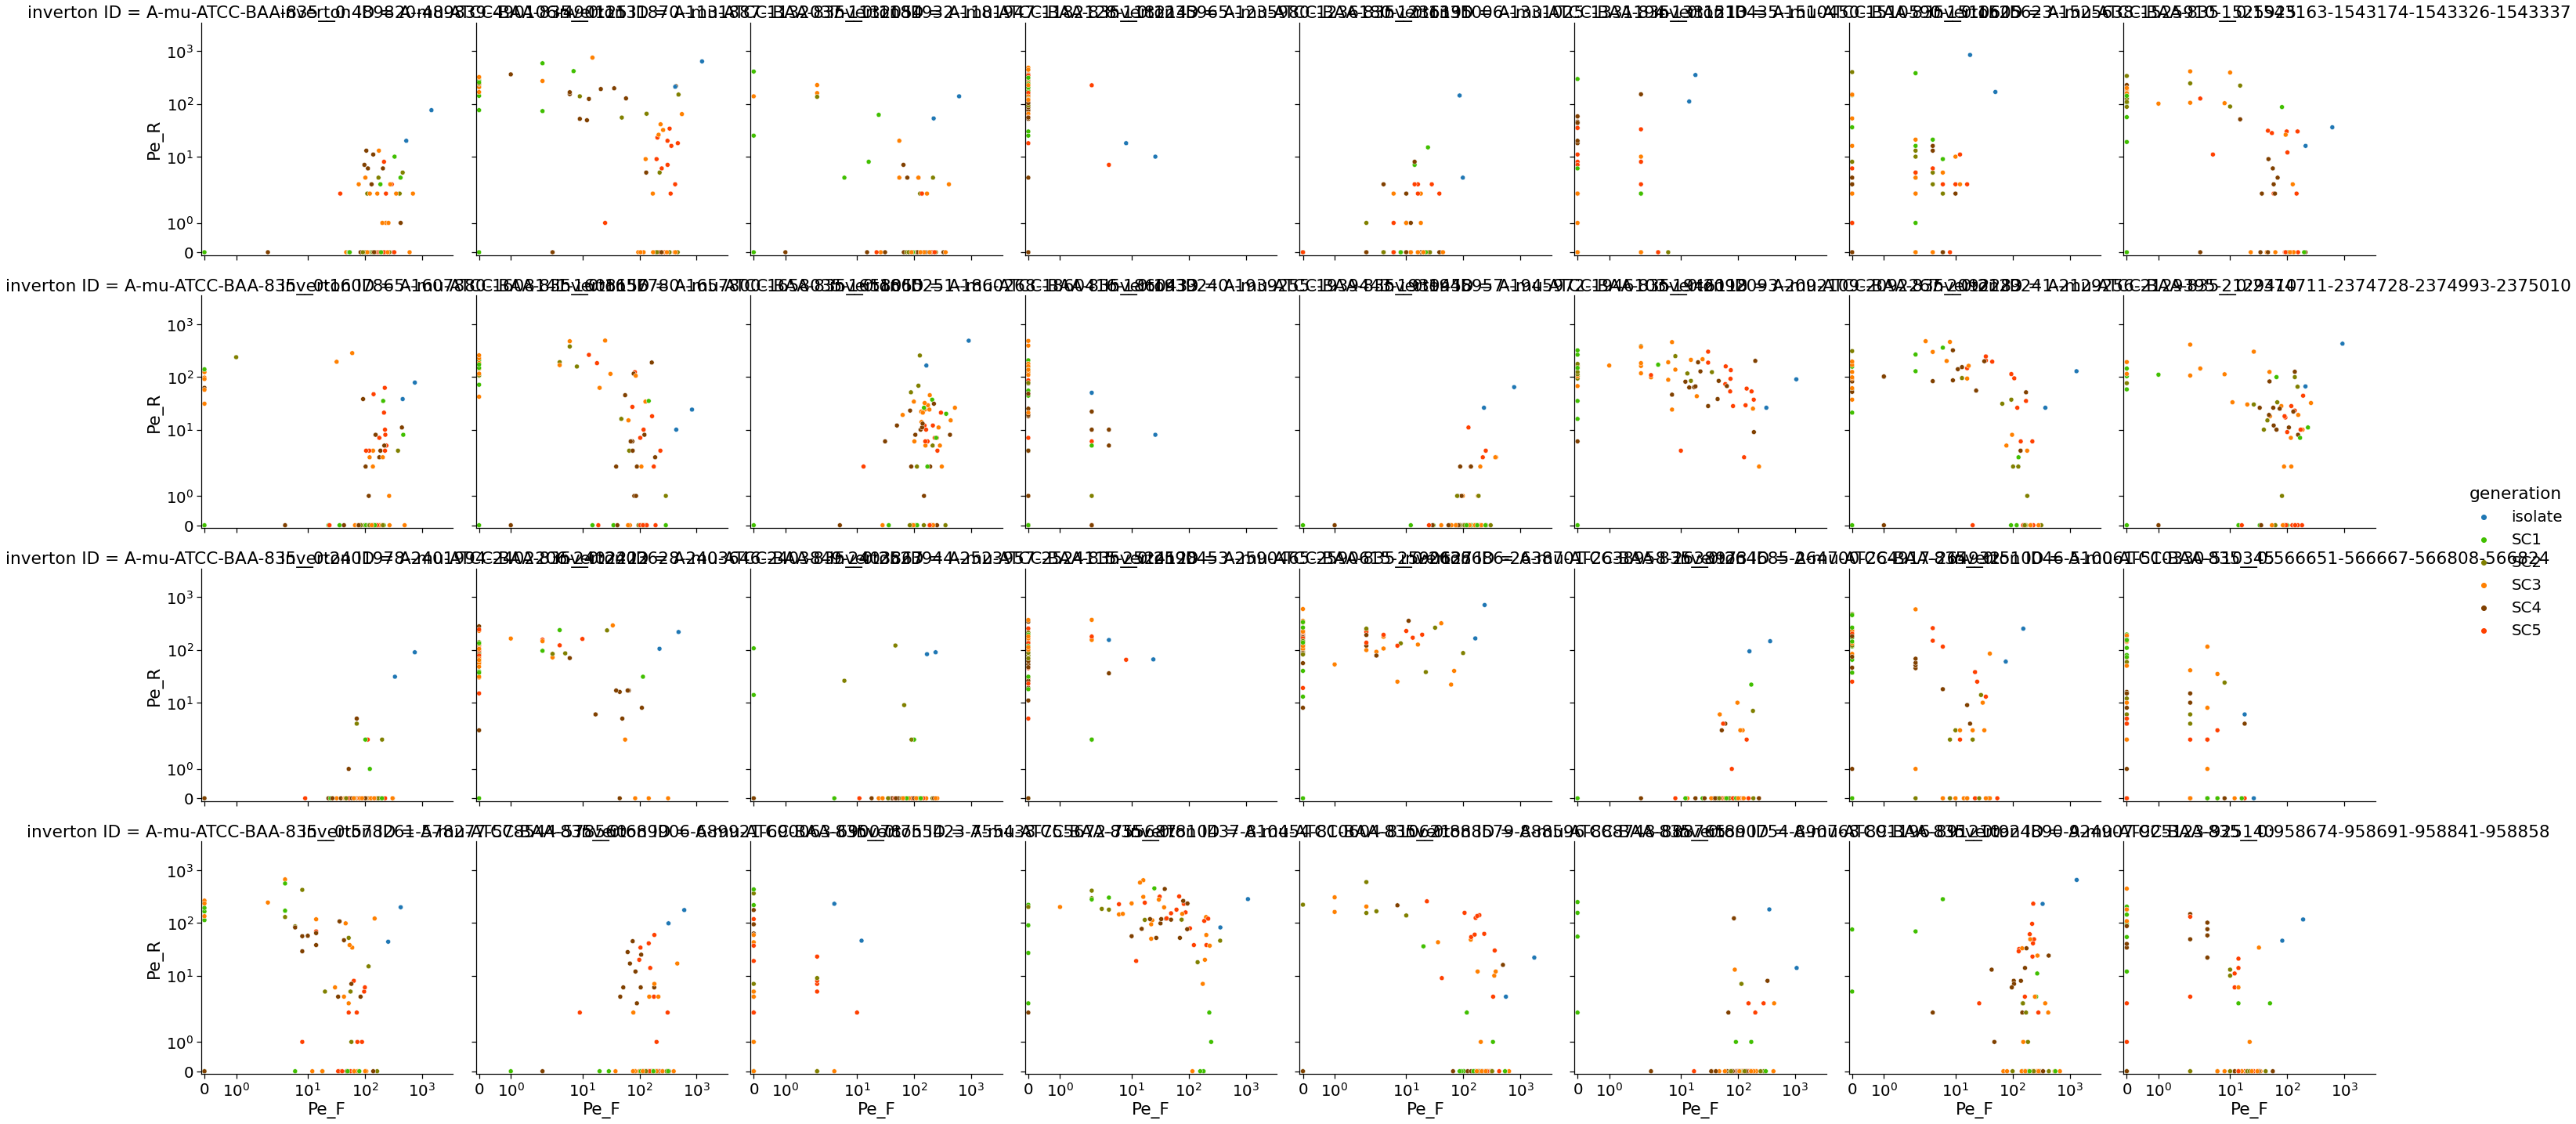

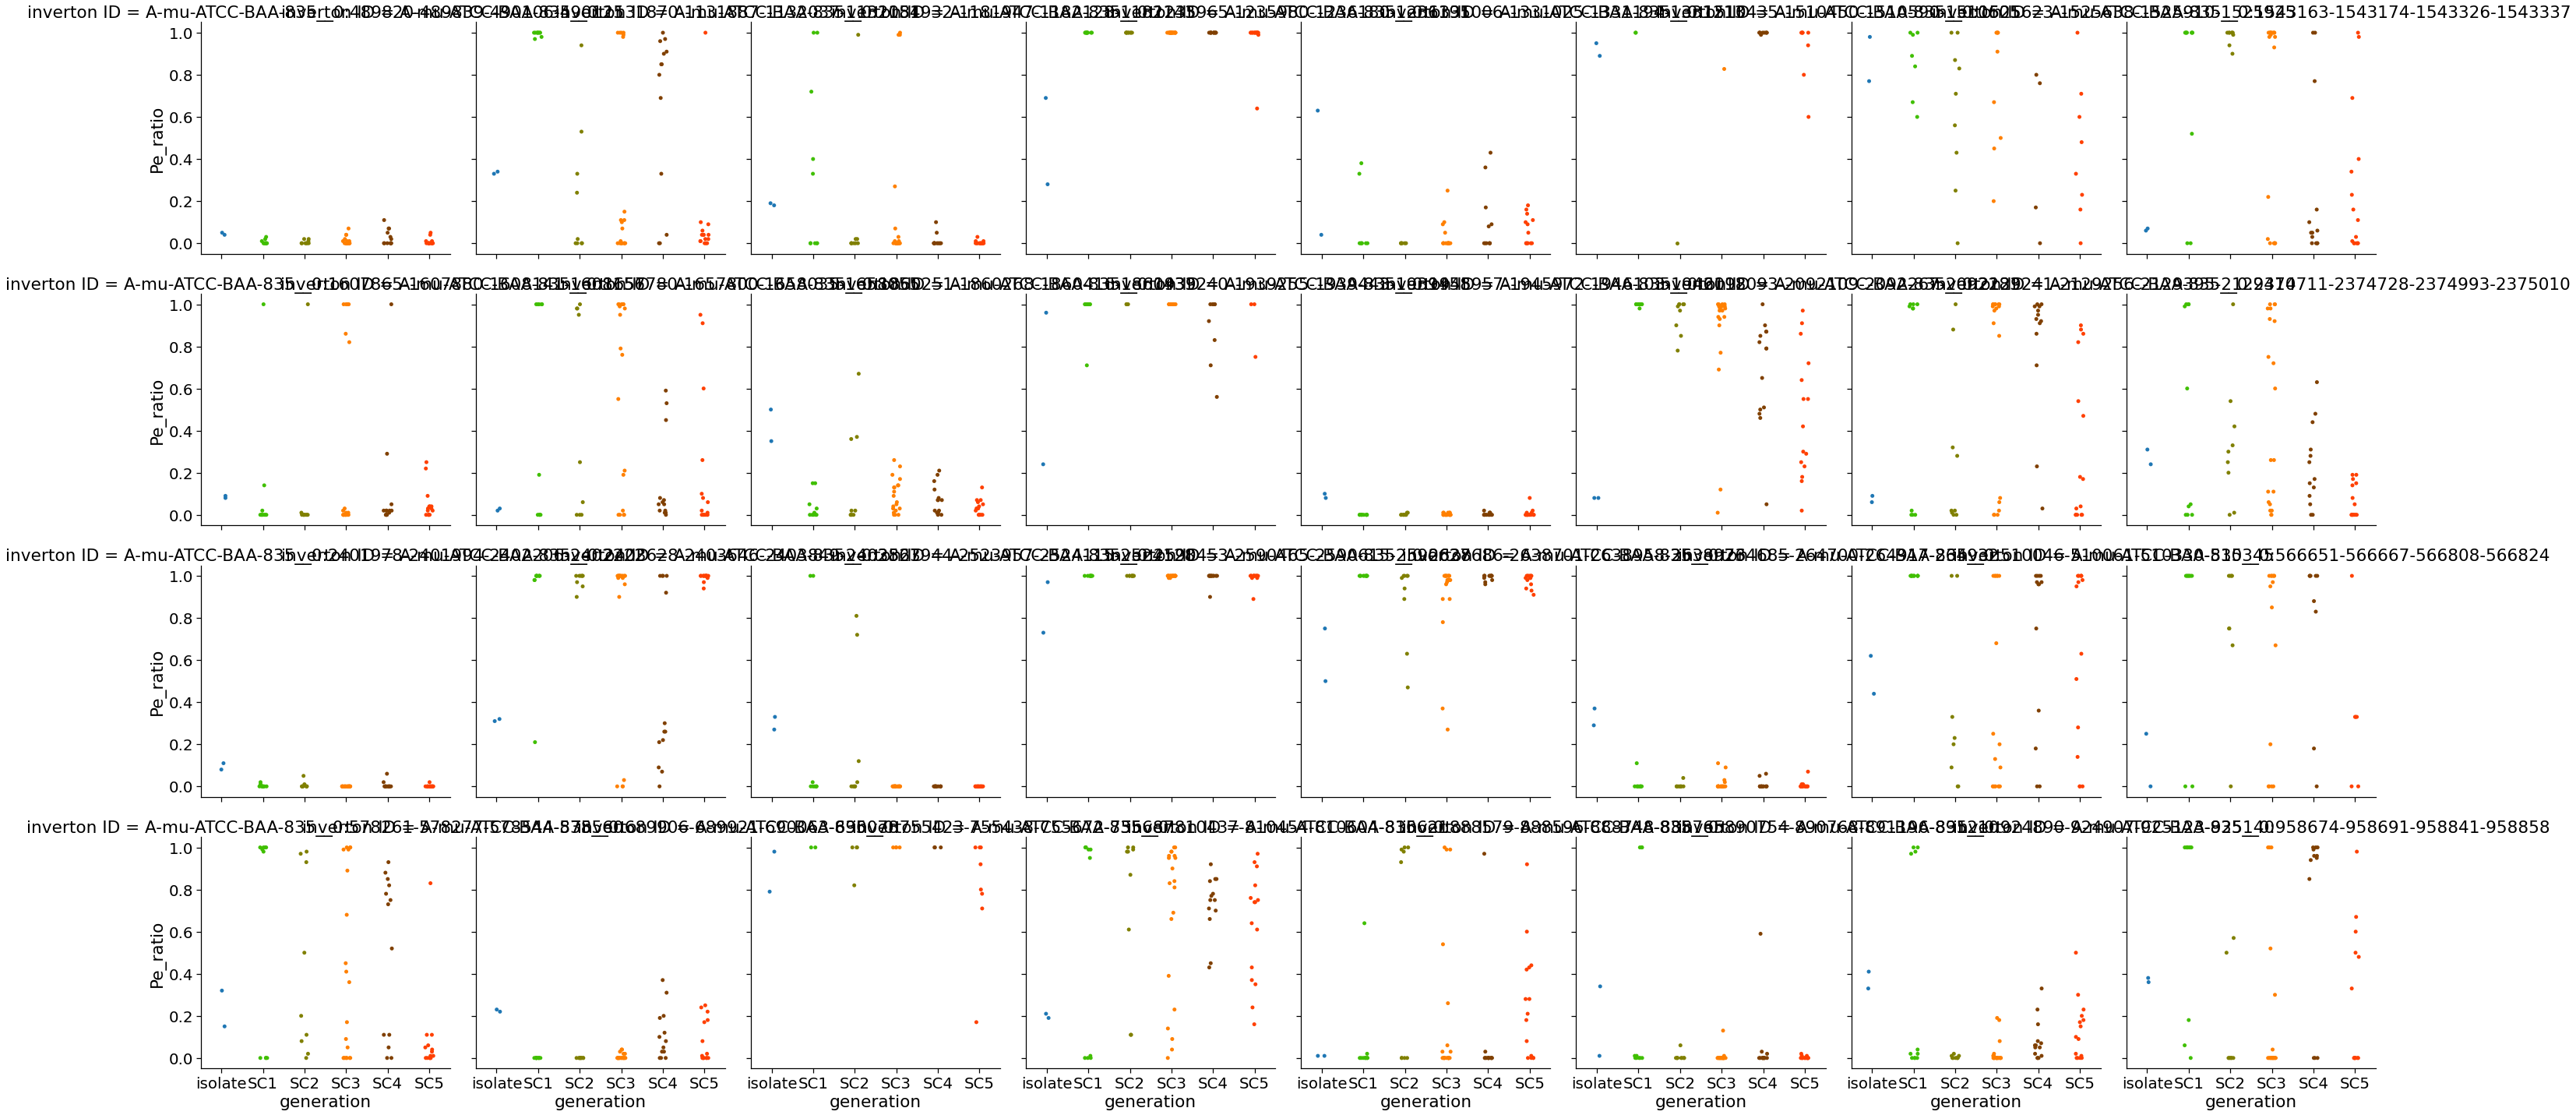

In [323]:
group138Invertons=invertonInfoDf[(invertonInfoDf['inverton group']==138)&(invertonInfoDf.Strain.str.contains('BAA-835'))]['inverton ID']


plotDf=invertonDf[(invertonDf['sample type']=='mouse stool')&(invertonDf['inverton ID'].isin(group138Invertons))]

plotDf=plotDf.merge(sampleDf[['sample','description']])
plotDf['gender']=[description.split(': ')[-1].split(' ')[0] for description in plotDf.description]
plotDf['generation']=[description.split(' ')[-1] for description in plotDf.description]

plotDf2=invertonDf[(invertonDf.apply(lambda row: row['Strain'] in row['sample'], axis=1))&(invertonDf['inverton ID'].isin(group138Invertons))]
plotDf2['generation']='isolate'
plotDf2['gender']='isolate'

plotDf=pd.concat([plotDf,plotDf2])
plotDf['Pe_tot']=plotDf['Pe_R']+plotDf['Pe_F']


with sns.plotting_context("notebook",font_scale=1.8):

    g=sns.relplot(x='Pe_F',y='Pe_R',hue='generation',col='inverton ID',
                  data=plotDf,
                  col_order=group138Invertons,
                 hue_order=['isolate','SC1','SC2','SC3','SC4','SC5'],
                 palette=["#1f77b4",(.25,.75,0),(.5,.5,0),(1,.5,0),(.5,.25,0),(1,.25,0)],
                 col_wrap=8)
    lim=2*np.max([plotDf.Pe_F.max(),plotDf.Pe_R.max()])
    g.set(xscale="symlog")
    g.set(xlim=[-.1,lim])

    g.set(yscale="symlog")
    g.set(ylim=[-.1,lim])
    g.savefig(os.path.join(workingDir,'figures','mouseGroup138AmuInvertonsPeRatios.pdf'))

    g2=sns.catplot(y='Pe_ratio',x='generation',hue='generation',col='inverton ID',#dodge=False,
                  data=plotDf[plotDf.Pe_tot>=5],
                  col_order=group138Invertons,
                  order=['isolate','SC1','SC2','SC3','SC4','SC5'],
                  hue_order=['isolate','SC1','SC2','SC3','SC4','SC5'],
                 palette=["#1f77b4",(.25,.75,0),(.5,.5,0),(1,.5,0),(.5,.25,0),(1,.25,0)],
                 col_wrap=8)
    g2.savefig(os.path.join(workingDir,'figures','mouseGroup138AmuInvertonsPeRatios.pdf'))    




/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/pollard/home/xiaofanj/miniconda3/envs/adhesins/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tup

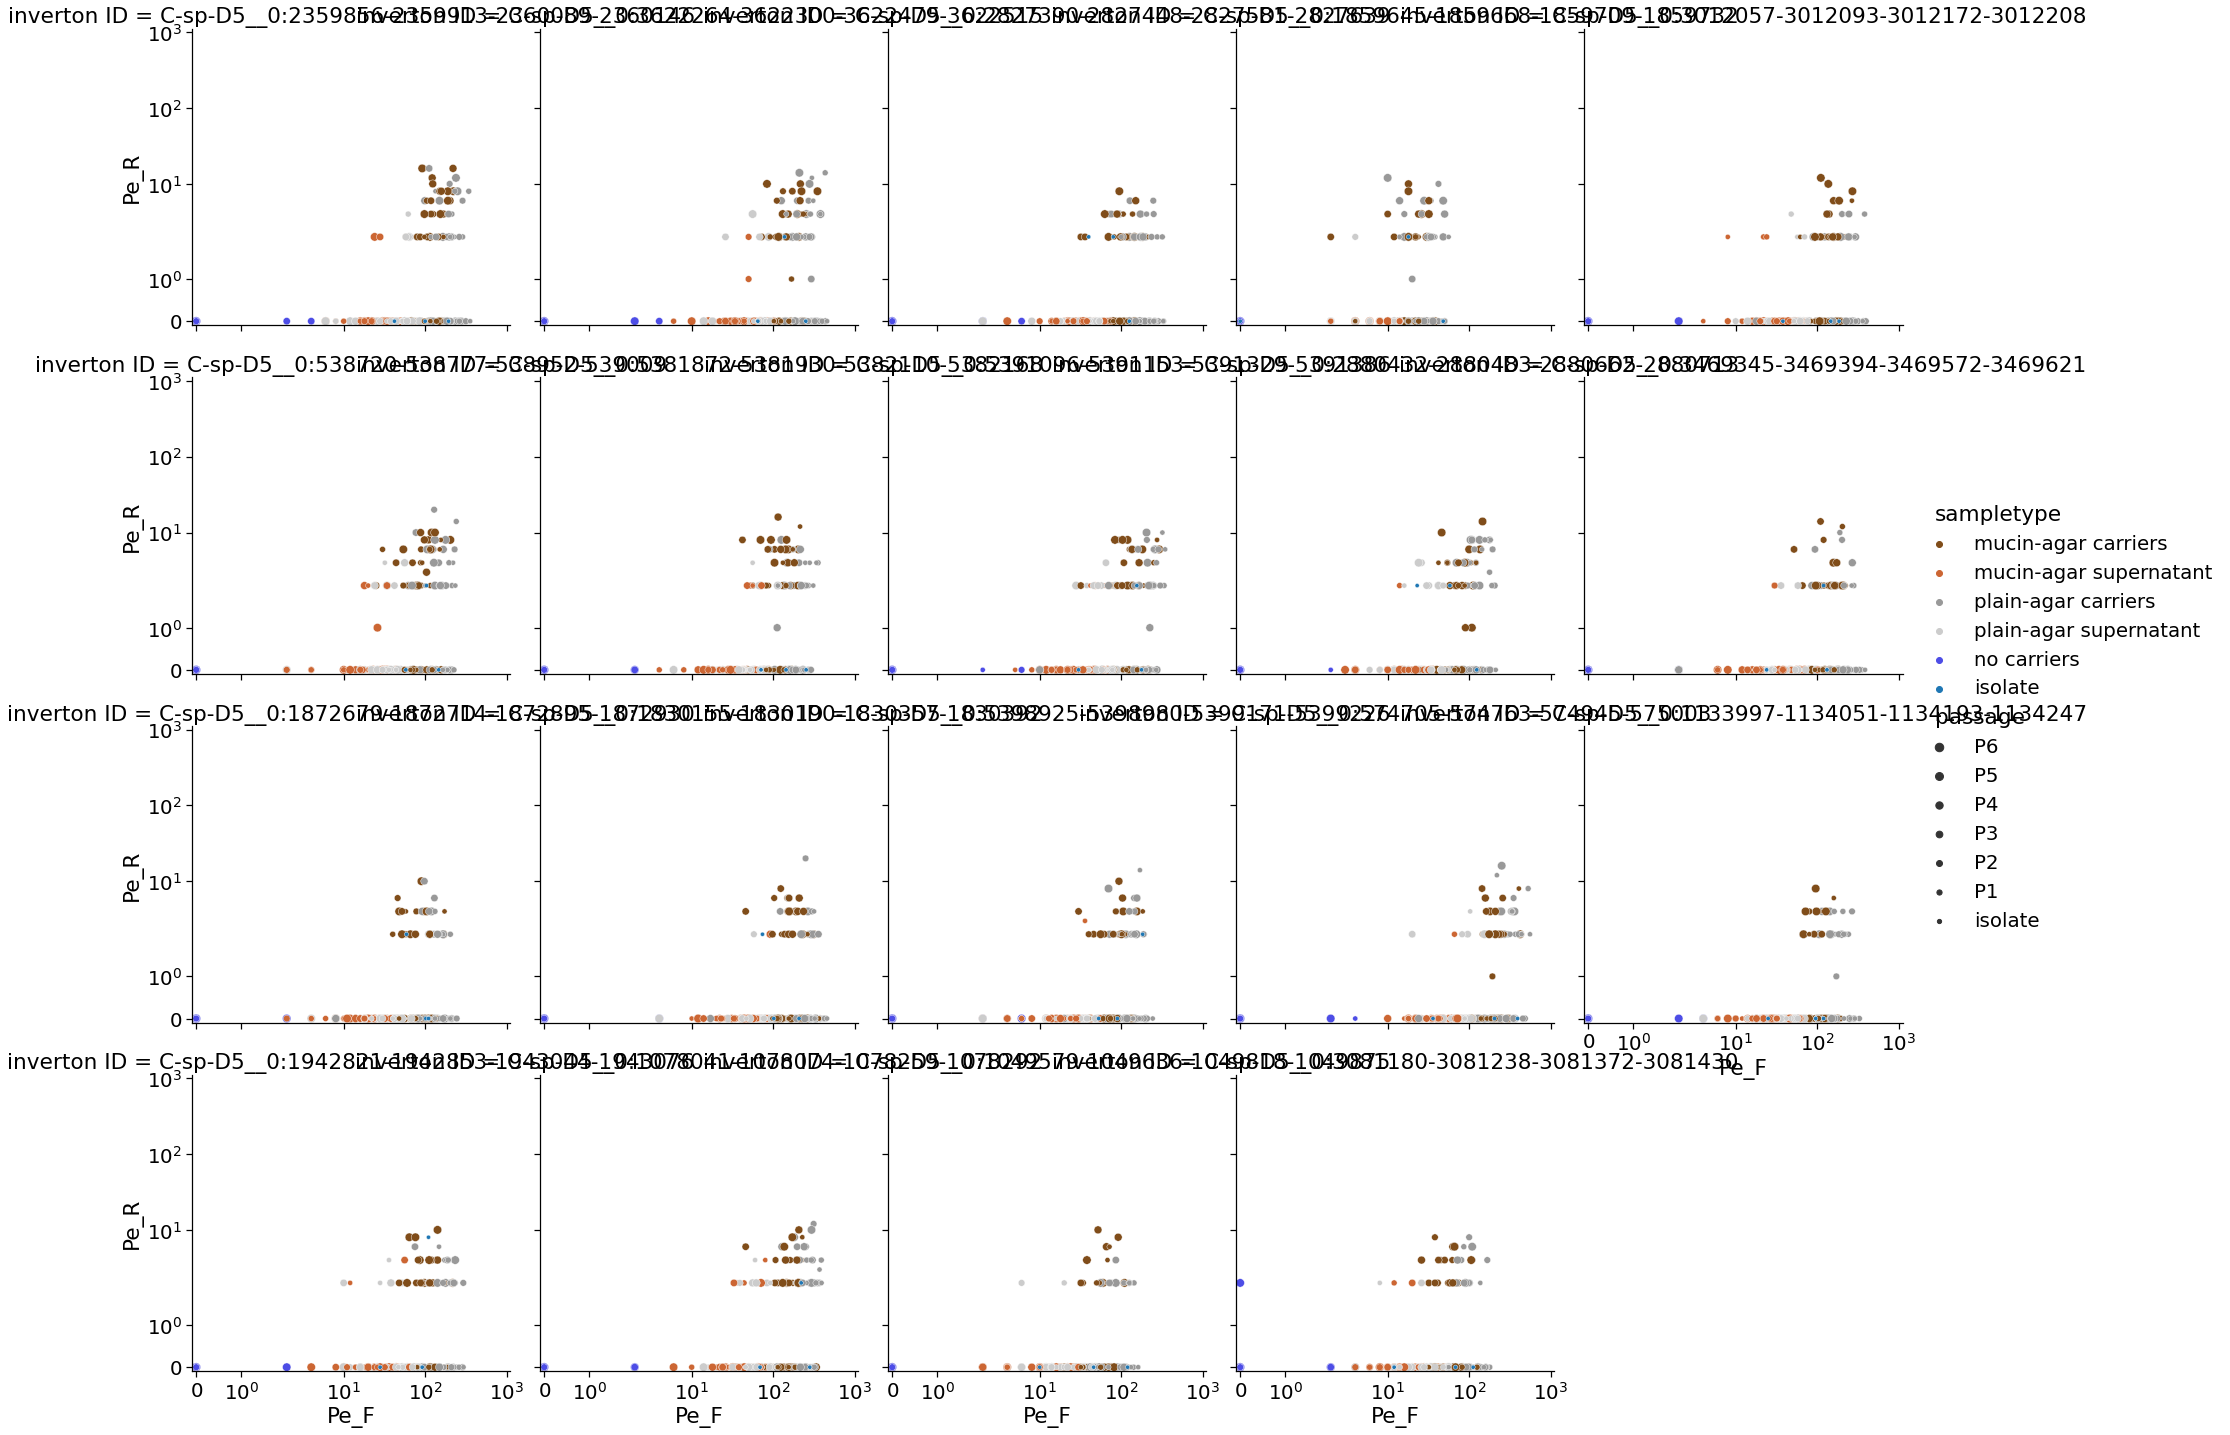

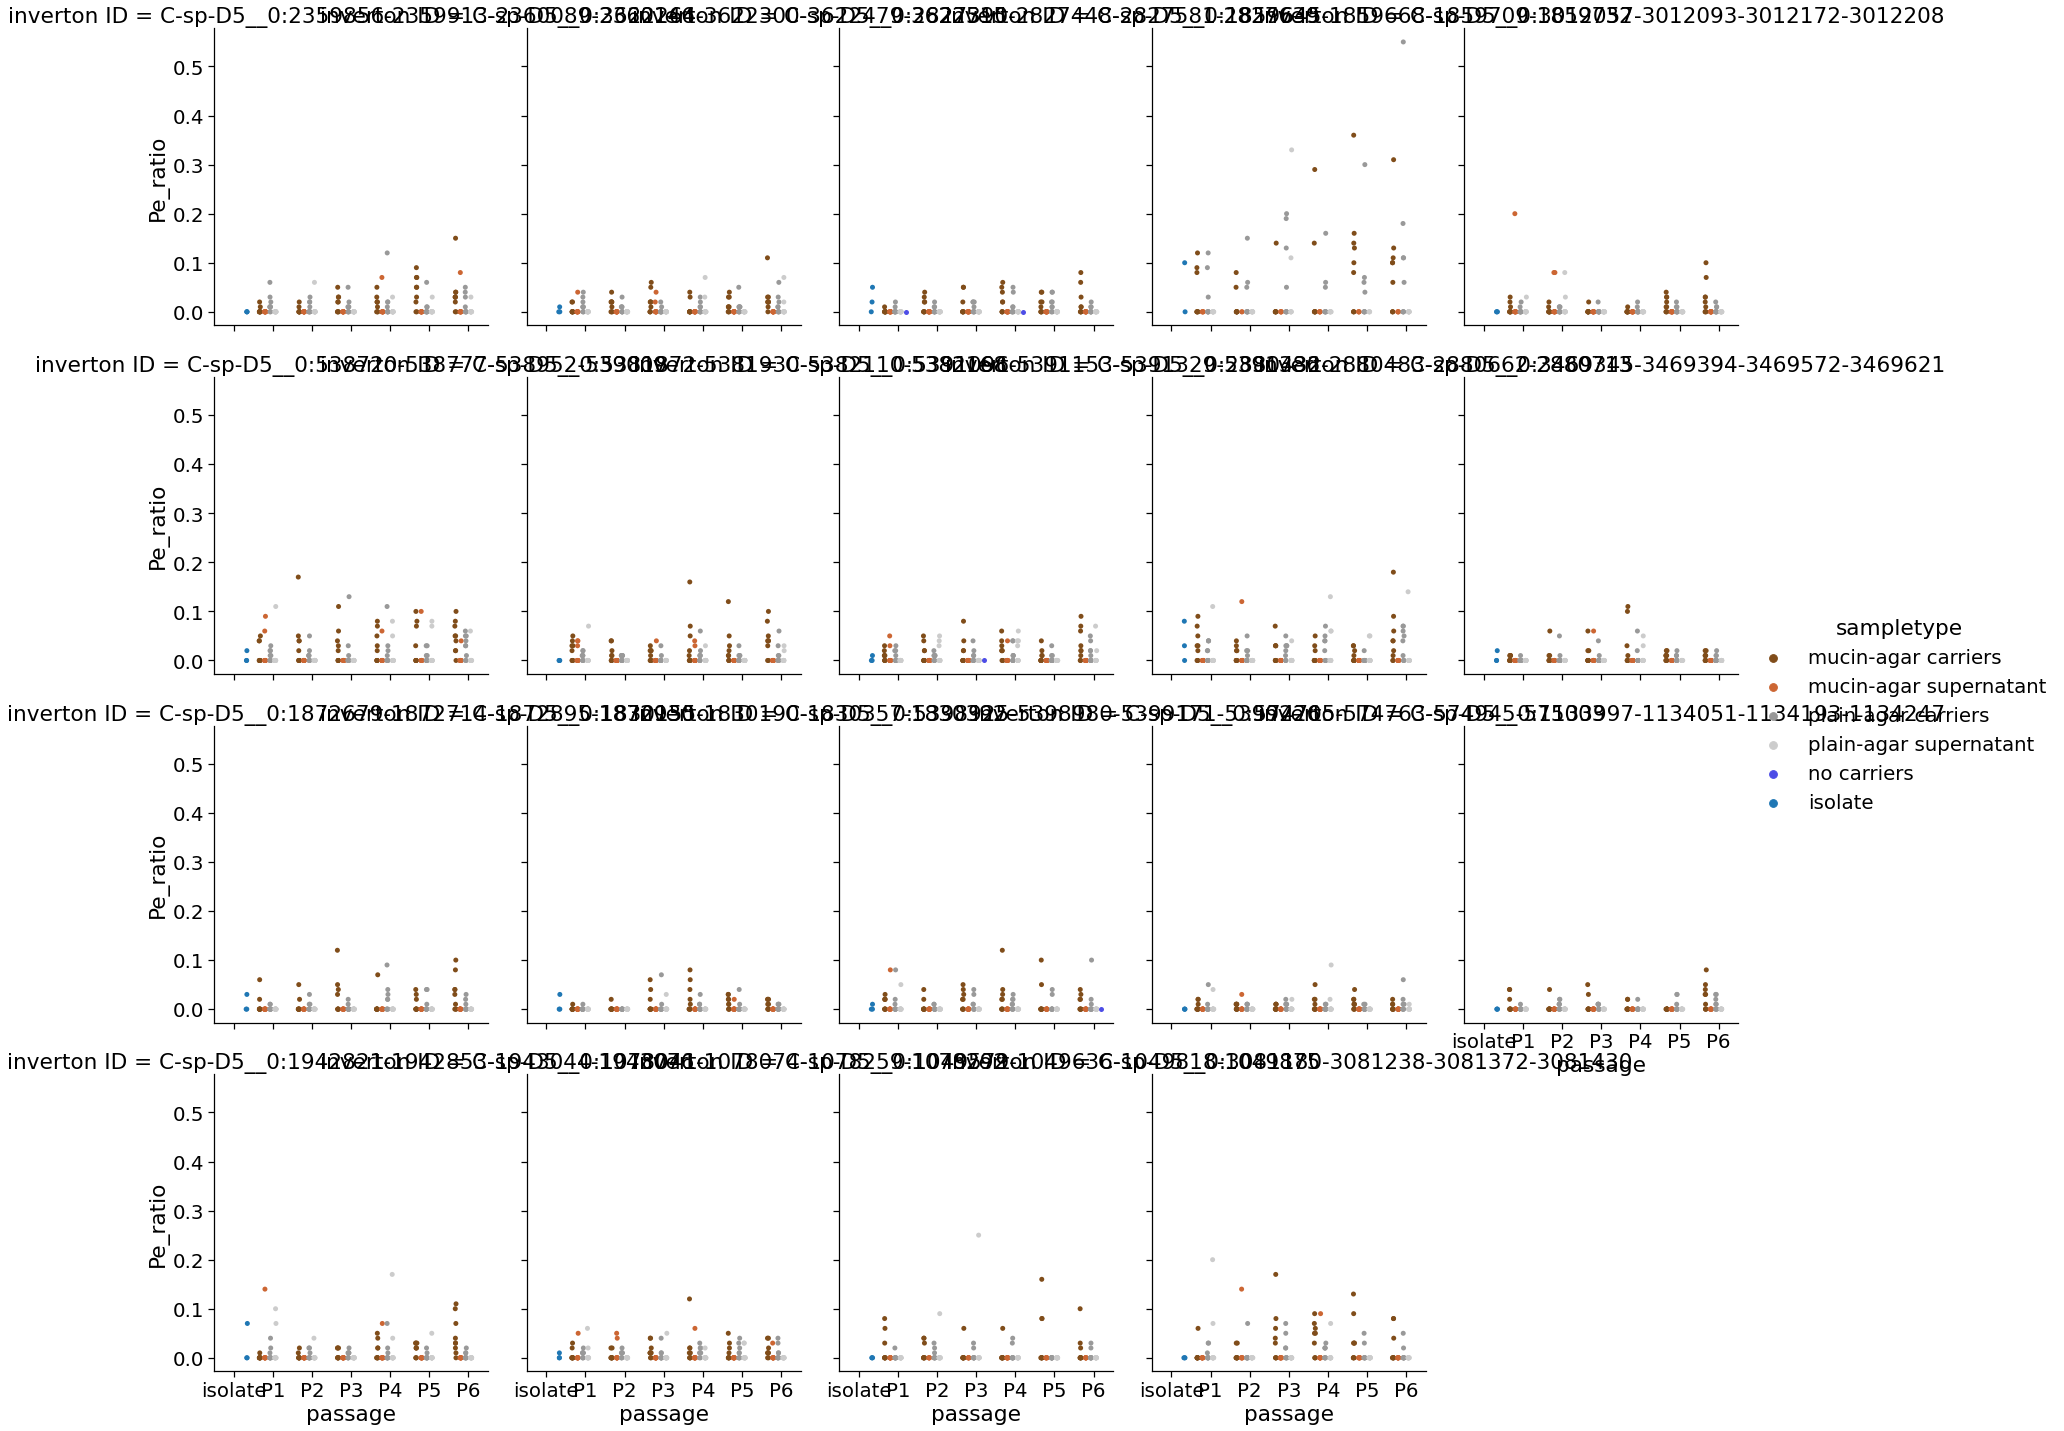

In [319]:
cspD5PlotInvertons=["C-sp-D5__0:2359856-2359913-2360089-2360146",
                    "C-sp-D5__0:3622264-3622300-3622479-3622515",
                    "C-sp-D5__0:2827390-2827448-2827581-2827639",
                    "C-sp-D5__0:1859645-1859668-1859709-1859732",
                    "C-sp-D5__0:3012057-3012093-3012172-3012208",
                    "C-sp-D5__0:538720-538777-538952-539009",
                    "C-sp-D5__0:5381872-5381930-5382110-5382168",
                    "C-sp-D5__0:5391096-5391153-5391329-5391386",
                    "C-sp-D5__0:2880432-2880483-2880662-2880713",
                    "C-sp-D5__0:3469345-3469394-3469572-3469621",
                    "C-sp-D5__0:1872679-1872714-1872895-1872930",
                    "C-sp-D5__0:1830155-1830190-1830357-1830392",
                    "C-sp-D5__0:5398925-5398980-5399171-5399226",
                    "C-sp-D5__0:574705-574763-574945-575003",
                    "C-sp-D5__0:1133997-1134051-1134193-1134247",
                    "C-sp-D5__0:1942821-1942853-1943044-1943076",
                    "C-sp-D5__0:1078041-1078074-1078259-1078292",
                    "C-sp-D5__0:1049579-1049636-1049818-1049875",
                    "C-sp-D5__0:3081180-3081238-3081372-3081430"]


plotDf=invertonDf[(invertonDf['sample type']=='in vitro mixed culture')&(invertonDf['sample'].str.contains('_P'))&(invertonDf['inverton ID'].isin(cspD5PlotInvertons))]
plotDf=plotDf.merge(sampleDf[['sample','description']])
plotDf['passage']=[description.split('passage ')[-1].split(',')[0] for description in plotDf.description]
plotDf['sampletype']=[description.split('in vitro culture of ')[-1].split(', passage')[0] for description in plotDf.description]

plotDf2=invertonDf[(invertonDf.apply(lambda row: row['Strain'] in row['sample'], axis=1))&(invertonDf['inverton ID'].isin(cspD5PlotInvertons))]
plotDf2['passage']='isolate'
plotDf2['sampletype']='isolate'

plotDf=pd.concat([plotDf,plotDf2])
plotDf['Pe_tot']=plotDf['Pe_R']+plotDf['Pe_F']

with sns.plotting_context("notebook",font_scale=1.8):
    
    g=sns.relplot(x='Pe_F',y='Pe_R',hue='sampletype',size='passage',col='inverton ID',
                  data=plotDf,
                  col_order=cspD5PlotInvertons,
                 size_order=np.flip(['isolate','P1','P2','P3','P4','P5','P6']),
                 palette=[(0.5,0.3,0.1),(0.8,0.4,0.2),(0.6,0.6,0.6),(0.8,0.8,0.8),(0.3,0.3,0.9),"#1f77b4"],
                 hue_order=['mucin-agar carriers',
                            'mucin-agar supernatant',
                            'plain-agar carriers',
                            'plain-agar supernatant',
                            'no carriers',
                            'isolate'],col_wrap=5)

    lim=2*np.max([plotDf.Pe_F.max(),plotDf.Pe_R.max()])
 
    g.set(xscale="symlog")
    g.set(xlim=[-.1,lim])

    g.set(yscale="symlog")
    g.set(ylim=[-.1,lim])
    g.savefig(os.path.join(workingDir,'figures','cspD5PlotInvertonsFRscatters.pdf'))


    g2=sns.catplot(y='Pe_ratio',x='passage',hue='sampletype',col='inverton ID',
                   dodge=True,
                  data=plotDf[plotDf.Pe_tot>=5],
                  col_order=cspD5PlotInvertons,
                   aspect=.9,
                  order=['isolate','P1','P2','P3','P4','P5','P6'],
                 palette=[(0.5,0.3,0.1),(0.8,0.4,0.2),(0.6,0.6,0.6),(0.8,0.8,0.8),(0.3,0.3,0.9),"#1f77b4"],
                 hue_order=['mucin-agar carriers',
                            'mucin-agar supernatant',
                            'plain-agar carriers',
                            'plain-agar supernatant',
                            'no carriers',
                            'isolate'],col_wrap=5)
    
    g2.savefig(os.path.join(workingDir,'figures','cspD5PlotInvertonsFRscattersPeRatios.pdf'))


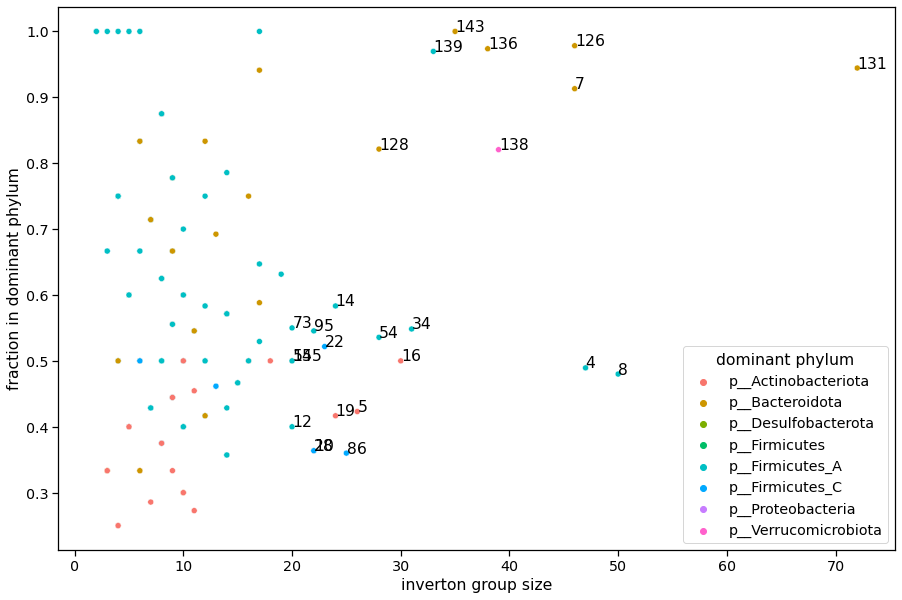

In [293]:
plotDf=invertonInfoDf.groupby('inverton group')['phylum'].agg(pd.Series.mode).rename('domPhylum').to_frame().join(invertonInfoDf.groupby('inverton group')['phylum'].count().rename('count'))
plotDf.index.name='clusterInd'
plotDf['domPhylum']=[domPhylum[0] if type(domPhylum) is np.ndarray else domPhylum for domPhylum in plotDf.domPhylum]

def getFracDomPhylum(clusterInd,domPhylum,invertonInfoDf=invertonInfoDf):
    aa=invertonInfoDf[invertonInfoDf['inverton group']==clusterInd]
    return (aa['phylum']==domPhylum).sum()/len(aa)


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(int(point['val'])))


plotDf['fracDomPhylum']=[getFracDomPhylum(clusterInd,domPhylum) for clusterInd,domPhylum in zip(plotDf.index,plotDf.domPhylum)]
with sns.plotting_context("notebook",font_scale=1.3):

    plt.figure(figsize=(15,10))
    g=sns.scatterplot(x='count',y='fracDomPhylum',hue='domPhylum',data=plotDf,
                     hue_order=np.sort(strainDf.phylum.unique()),palette=ggtreeCmap)

    for x,y,lab in zip(plotDf['count'], plotDf.fracDomPhylum, pd.Series(plotDf.index.values.astype(int))):
        if x>=20:
            g.text(x+.02, y, lab)
    g.legend(title='dominant phylum')
    g.set_xlabel('inverton group size')
    g.set_ylabel('fraction in dominant phylum')
    plt.savefig(os.path.join(workingDir,'figures','dominantPhylumBySizeScatterplot.pdf'))

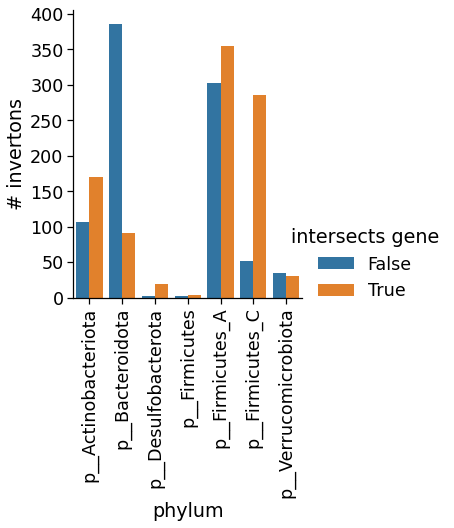

In [297]:
with sns.plotting_context("notebook",font_scale=1.6):
    g=sns.catplot(kind='bar',x='phylum',hue='intersectGene',y='inverton ID',legend_out=True,
                data=invertonInfoDf.groupby(['phylum','intersectGene'])['inverton ID'].count().reset_index())
    g.set_xticklabels(g.axes.flat[-1].get_xticklabels(), rotation=90)
    g._legend.set_title('intersects gene')
    g.set(ylabel='# invertons')
    g.savefig(os.path.join(workingDir,'figures','intersectIntergenicCountsByPhylum.pdf'))

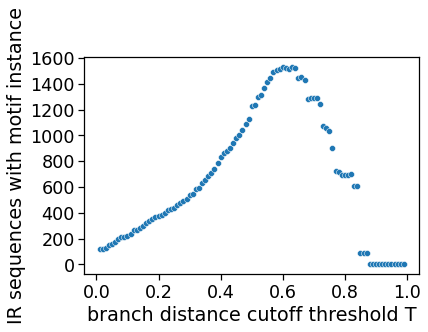

In [306]:
df=pd.DataFrame([(thresholdPercent/100,
                  countTotalSitesFolder(os.path.join(workingDir,'data','memeOutput','thresholdSearch',f'invertonsIRseqs_treeCluster{thresholdPercent:02d}'))) 
                 for thresholdPercent in range(1,100)],
               columns=['threshold',
                        'motifSeqsFound',])

with sns.plotting_context("notebook",font_scale=1.6):
    plt.figure()
    g=sns.scatterplot(x='threshold',y='motifSeqsFound',data=df)
    g.set_xlabel('branch distance cutoff threshold T')   
    g.set_ylabel('IR sequences with motif instance')
    plt.savefig(os.path.join(workingDir,'figures','MEMEsitesFoundByTreeclusterThreshold.pdf'))


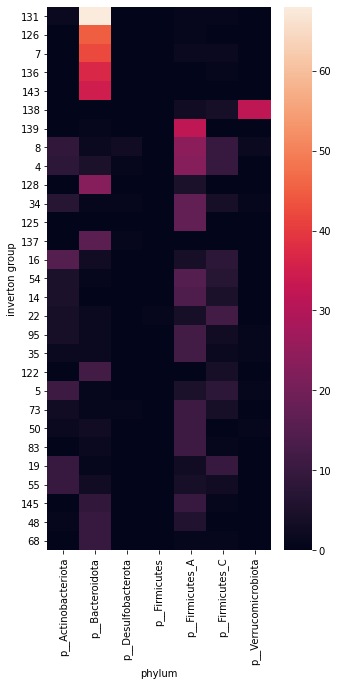

In [308]:
plotDf=invertonInfoDf.groupby(['inverton group','phylum'])['inverton ID'].count().unstack().fillna(0).astype(int)
plotDf['max']=plotDf.max(axis=1)
plotDf['total']=plotDf.sum(axis=1)-plotDf['max']


fig=plt.figure(figsize=(5,10))
g=sns.heatmap(plotDf[plotDf['max']>=10].sort_values(by=['max','total'],ascending=False)[[col for col in plotDf if 'p__' in col]])
g.set_ylabel('inverton group')
fig.savefig(os.path.join(workingDir,'figures','top29HeatmapByPhyla.pdf'))


In [326]:
mousePlotInvertons=['A-mu-ATCC-BAA-835__0:2092093-2092109-2092267-2092283',
                   'B-ce-DSM-14838__0:4484223-4484241-4484427-4484445',
                   'B-ce-DSM-14838__0:137243-137258-137893-137908']
invertonInfoDf[invertonInfoDf['inverton ID'].isin(mousePlotInvertons)]


,inverton ID,inverton group,intersectGene,IR sequence,full sequence,abbrev,Strain,phylum,chrom,start_IR1,end_IR1,start_IR2,end_IR2
173,A-mu-ATCC-BAA-835__0:2092093-2092109-2092267-2092283,138,False,CGGATTAGCAATCCGC,CGGATTAGCAATCCGCAGAAGCATTATCCAGAAAATAGACCAGAATCAGATATTTTTGATGTTTATAATGAAAGAGATATGGAATGTTTTTTTGAAAAAATTCTGAATTGGATATTAAGAAGATGATGATTTCCTGGTATGCAACATGCATTGGATCAATGTTAAATATTGACGGCGGATTGCTAATTCG,A-mu-ATCC-BAA-835,Akkermansia-muciniphila-ATCC-BAA-835,p__Verrucomicrobiota,A-mu-ATCC-BAA-835__0,2092093,2092109,2092267,2092283
332,B-ce-DSM-14838__0:4484223-4484241-4484427-4484445,143,False,TTTTAATCGTTCGTTTAA,TTTTAATCGTTCGTTTAATGTGCGCAAAGATAATGCCCAGAAATGAAACAACAAAATATTCTGATAAAGAAAAATTAAATATTTTCTTTTTGCCTATATATATTACTAATATATAGCCTGTTACCTTTGAAATGAGATTGTAATTTTGAGATTACTTTCTTGTTGAAAGAATCTTAGTATGAAAACAACCTTCCAACCTATCTTTTAAACGAACGATTAAAA,B-ce-DSM-14838,Bacteroides-cellulosilyticus-DSM-14838,p__Bacteroidota,B-ce-DSM-14838__0,4484223,4484241,4484427,4484445
347,B-ce-DSM-14838__0:137243-137258-137893-137908,131,False,GTTCTAGCAGAACTT,GTTCTAGCAGAACTTATGAAAAGCAAATTCTCAACAGTTATTTTTTATTATTCAAAATAGCTTGTTCGTTATGAAAAATTTCATTTGAATGTAATCAATGAGATTATATCTAAAAAACAAACTCATAGTTTACATTTGCTTTTATGTTAACATTAATGCCTTTTTCTATAAAGCGATGCTATTTTTATGTTATTAACAACAAAAGAATCTTTATTATTCACTAAAACAAAGCATATTTCTATCATTTTGCTTTTTAAAGCAATCATATAATCACTATCTTCTTGATTAAAAACAGATATAAATGTAATATAAACACTTAACCAAATACATATTCAAACAATATGTATTTGCAAGTATTTTAGATTTTATTTCGTATTTTGTTTTGATTTTATAAAACATTACTTAATTTTGCAGCTGTGGAACATGAATAAACGACTATGCTTTCAGAGGATATGATCAAAACACATTTACGAAAGAAAGATTAATGTCATTCTTCATCTACACTTCAAATAAATATATAGCTCAAAGTTTGAAAAGATAATAAAAATCTATATTCCTGAAAAAGTAACAGAAGTATCATGAAAACAACAGCTACGGTAGAAGCAAATATTTGCTAATATCATTGATTAGTACACTTTAACCAATCTATCAAGTTCTGCTAGAAC,B-ce-DSM-14838,Bacteroides-cellulosilyticus-DSM-14838,p__Bacteroidota,B-ce-DSM-14838__0,137243,137258,137893,137908


In [ ]:
fimoBed.intersect(irBed,wa=True).to_dataframe()


In [338]:
promotersDf=fimoBed.intersect(irBed,wa=True).to_dataframe().merge(upstreamMotifDf.rename(columns={'motif ID':'name'}),on='name')
promotersDf['strand_promoter']=['+' if (motifOnGeneStrand and strand=='+')or(not motifOnGeneStrand and strand=='-') else '-' for motifOnGeneStrand,strand in zip(promotersDf.motifOnGeneStrand,promotersDf.strand)]
promotersDf

,chrom,start,end,name,score,strand,motifOnGeneStrand,positionWrtGene,strand_promoter
0,P-di-ATCC-8503__0,3020766,3020799,131-2,2.670000e-10,+,True,upstream,+


In [329]:
fimoBed.to_dataframe()

,chrom,start,end,name,score,strand
0,A-ca-DSM-14662__0,17264,17362,96-1,4.920000e-12,+
1,A-ca-DSM-14662__0,38828,38846,92-1,7.170000e-09,+
2,A-ca-DSM-14662__0,85113,85211,96-1,5.510000e-12,+
3,A-ca-DSM-14662__0,98041,98109,131-5,7.440000e-09,+
4,A-ca-DSM-14662__0,152462,152490,42-1,8.400000e-10,+
...,...,...,...,...,...,...
41693,V-sp-6-1-27__0,1940098,1940153,137-5,4.080000e-09,-
41694,V-sp-6-1-27__0,1970458,1970497,131-9,1.270000e-09,+
41695,V-sp-6-1-27__0,2120117,2120146,4-1,7.000000e-09,+
41696,V-sp-6-1-27__0,2130490,2130545,122-3,4.540000e-09,+


In [343]:
mousePlotInvertons=['A-mu-ATCC-BAA-835__0:2092093-2092109-2092267-2092283',
                   'B-ce-DSM-14838__0:4484223-4484241-4484427-4484445',
                   'B-ce-DSM-14838__0:137243-137258-137893-137908']
plotDf=invertonInfoDf[invertonInfoDf['inverton ID'].isin(mousePlotInvertons)]
maxLen=0

for row in plotDf.iterrows():
    gd_diagram = GenomeDiagram.Diagram("mouse enriched inverton")

    maxLen=0
    slopSize=2000
    Strain_Name=row[1].chrom.split('__')[0]
    
    start=row[1].start_IR1-slopSize
    end=row[1].end_IR2+slopSize
    maxLen=np.max([maxLen,end-start])
    irBed=pybedtools.bedtool.BedTool(f"{row[1].chrom} {row[1].start_IR1} {row[1].end_IR2}",from_string=True)

    irFeatures=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    promotersDf=fimoBed.intersect(irBed,wa=True).to_dataframe()
    if len(promotersDf)>0:
        promotersDf=promotersDf.merge(upstreamMotifDf.rename(columns={'motif ID':'name'}),on='name')
        promotersDf['strand_promoter']=['+' if (motifOnGeneStrand and strand=='+')or(not motifOnGeneStrand and strand=='-') else '-' for motifOnGeneStrand,strand in zip(promotersDf.motifOnGeneStrand,promotersDf.strand)]
    featuresDf=pgapBed.intersect(irBed.slop(b=slopSize,g=os.path.join(workingDir,'data','geneAnnotations','hCom2.chromsizes')),wa=True).to_dataframe()
    if len(featuresDf)>0:
        featuresDf=featuresDf.merge(invertaseDf.loc[invertaseDf['invertase group']==invertaseGroup,['chrom','start','end','invertase group']],on=['chrom','start','end'],how='left').fillna(-1)
        features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(featureRow[1].start), int(featureRow[1].end)), strand=int(f"{featureRow[1].strand}1"),type="gene",id=str(int(featureRow[1]['invertase group']))) for featureRow in featuresDf.iterrows()]
        features=features+irFeatures
    else:
        features=irFeatures
    if len(promotersDf)>0:
        promoters=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start, row[1].end), strand=int(f"{row[1].strand_promoter}1"),type="promoter",id='promoter') for row in promotersDf.iterrows()]
        features=features+promoters
    features=[shiftFeature(feature,start) for feature in features]

    for feature in features:
        if feature.id=='35':
            color=Color(0,1,1,0.5)
        elif feature.id=='-1':
            color=Color(.6,.6,.6,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)
    gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                    fragments=1)# start=0, end=np.max([extentTuple[1]-extentTuple[0] for extentTuple in extentTuples]))

    gd_diagram.write(os.path.join(workingDir,'figures','mousePlotInvertons.png'), "png")
    gd_diagram.write(os.path.join(workingDir,'figures',f"mousePlotInvertons{row[1]['inverton ID']}.svg"), "svg")
Image(filename=os.path.join(workingDir,'figures','mousePlotInvertons.png')) 
    


In [344]:
invitroPlotInvertons=['I-bu-DSM-26588__0:1750639-1750652-1750880-1750893',
                        'B-ca-ATCC-43185__0:1936309-1936332-1936691-1936714',
                        'C-sp-D5__0:3525576-3525601-3525807-3525832',
                        'M-DS-102144__0:1932707-1932720-1933121-1933134']
plotDf=invertonInfoDf[invertonInfoDf['inverton ID'].isin(invitroPlotInvertons)]
maxLen=0

for row in plotDf.iterrows():
    gd_diagram = GenomeDiagram.Diagram("mouse enriched inverton")

    maxLen=0
    slopSize=2000
    Strain_Name=row[1].chrom.split('__')[0]
    
    start=row[1].start_IR1-slopSize
    end=row[1].end_IR2+slopSize
    maxLen=np.max([maxLen,end-start])
    irBed=pybedtools.bedtool.BedTool(f"{row[1].chrom} {row[1].start_IR1} {row[1].end_IR2}",from_string=True)

    irFeatures=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR1), int(row[1].end_IR1)), strand=1,type="IR",id=f"IR_1"),
              SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(row[1].start_IR2), int(row[1].end_IR2)), strand=-1,type="IR",id=f"IR_2")]
    
    gd_track_for_features = gd_diagram.new_track(1, name=row[0],scale=1,scale_ticks=0,start=0, end=end-start)
    gd_feature_set = gd_track_for_features.new_set()
    promotersDf=fimoBed.intersect(irBed,wa=True).to_dataframe()
    if len(promotersDf)>0:
        promotersDf=promotersDf.merge(upstreamMotifDf.rename(columns={'motif ID':'name'}),on='name')
        promotersDf['strand_promoter']=['+' if (motifOnGeneStrand and strand=='+')or(not motifOnGeneStrand and strand=='-') else '-' for motifOnGeneStrand,strand in zip(promotersDf.motifOnGeneStrand,promotersDf.strand)]
    featuresDf=pgapBed.intersect(irBed.slop(b=slopSize,g=os.path.join(workingDir,'data','geneAnnotations','hCom2.chromsizes')),wa=True).to_dataframe()
    if len(featuresDf)>0:
        featuresDf=featuresDf.merge(invertaseDf.loc[invertaseDf['invertase group']==invertaseGroup,['chrom','start','end','invertase group']],on=['chrom','start','end'],how='left').fillna(-1)
        features=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(int(featureRow[1].start), int(featureRow[1].end)), strand=int(f"{featureRow[1].strand}1"),type="gene",id=str(int(featureRow[1]['invertase group']))) for featureRow in featuresDf.iterrows()]
        features=features+irFeatures
    else:
        features=irFeatures
    if len(promotersDf)>0:
        promoters=[SeqFeature.SeqFeature(SeqFeature.FeatureLocation(row[1].start, row[1].end), strand=int(f"{row[1].strand_promoter}1"),type="promoter",id='promoter') for row in promotersDf.iterrows()]
        features=features+promoters
    features=[shiftFeature(feature,start) for feature in features]

    for feature in features:
        if feature.id=='35':
            color=Color(0,1,1,0.5)
        elif feature.id=='-1':
            color=Color(.6,.6,.6,0.5)
        elif feature.type=='IR':
            color=Color(0,0,0,0.5)
        if feature.strand==-1:
            label_angle=-135
        else:
            label_angle=45
        name = feature.id
        gd_feature_set.add_feature(feature, color=color, label=True, name=name,label_angle=label_angle,
                                  sigil="BIGARROW", arrowshaft_height=1.0)
    gd_diagram.draw(format="linear", orientation="landscape", pagesize=((maxLen/1000)*inch,(len(plotDf)/20)*inch),
                    fragments=1)

    gd_diagram.write(os.path.join(workingDir,'figures','invitroPlotInvertons.png'), "png")
    gd_diagram.write(os.path.join(workingDir,'figures',f"invitroPlotInvertons{row[1]['inverton ID']}.svg"), "svg")
Image(filename=os.path.join(workingDir,'figures','invitroPlotInvertons.png')) 
    
